# Packages and functions

In [1]:
# import packages

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math
import os,glob
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm,trange
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from nilearn.masking import apply_mask

# nltools
from nltools.prefs import MNI_Template, resolve_mni_path
from nltools.data import Brain_Data,Adjacency
from nltools.mask import expand_mask
from nltools.stats import matrix_permutation,fdr
from nltools.utils import check_square_numpy_matrix
from nltools.plotting import plot_glass_brain,plot_stat_map

# scipy
from scipy import stats
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform

In [2]:
# path

fpath = os.path.abspath('../Fmri')
beiscpath = os.path.abspath('../Data/behavior_ISC')
briscpath = os.path.abspath('../Data/brain_ISC')
rpath = os.path.abspath('../Results')

In [3]:
# Brain ISC

# ROI 50
mask50 = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
allmask50 = expand_mask(mask50)
name50 = pd.read_excel(os.path.abspath('../Data/roi50.xlsx'))
name50 = name50.set_index('Parcel')[['Name']].T.to_dict('record')[0]

def brain_isc(brain_name, roi, method):
    
    brain = Brain_Data(os.path.join(fpath,f'{brain_name}.nii.gz'))
    allmasks = allmask50
        
    adj = Adjacency()
    
    metric = 'correlation'
    if method == 'euclidean':
        metric = method
    
    for i in trange(roi):
        Brain_roi= brain.apply_mask(allmask50[i])
        adj = adj.append(Brain_roi.distance(metric=f'{metric}'))
        
    if method == 'correlation':
        adj = 1 - adj
    
    adj.write(os.path.join(briscpath,f'{brain_name}_roi{roi}_{method}_brain_isc.csv'))

In [4]:
# Behavior ISC

def behavior_isc(data, eucor):

    data_dist = pdist(data, metric= eucor)
    data_dist_square = distance.squareform(data_dist)
    data_dist_square = pd.DataFrame(data_dist_square)
    
    return data_dist_square

def subscales_isc(name, eucor, sub_list, sub_name, draw=False):
    
    data = pd.read_csv(os.path.join(dpath,f"{name}.csv")).iloc[:,2:]
    
    for i in range(len(sub_list)):
        
        index = [j-1 for j in sub_list[i]]
        
        dataa = data.iloc[:,index]
            
        namee = sub_name[i]
        data_dist_square = behavior_isc(dataa, eucor)

        if draw == True:
            plt.figure(figsize=(9,6))

            mask = np.zeros_like(data_dist_square)
            mask[np.triu_indices_from(mask)] = True

            ax=plt.axes()
            ax = sns.heatmap(data_dist_square, mask=mask,linewidths=0.1,cmap = 'RdBu_r')

            ax.set_title(f"{name} {namee} {eucor} distance")
    
        data_dist_square.to_csv(os.path.join(beiscpath,f'{name}_{namee}_{eucor}_isc.csv'))
        
        if draw == True:
            plt.show()

In [5]:
# ISRSA

def read_behavior_csv(Q):
    data = pd.read_csv(Q, index_col=0, float_precision='round_trip')
    return data

def single_ISRSA(brain_name, behavior, roi, coreu):
    
    # ISC metric
    if coreu == 'eucosine':
        method = 'euclidean'
        beMethod = 'cosine'
        
    # Brain ISC
    mov_transpose = pd.read_csv(os.path.join(briscpath,f'{brain_name}_roi{roi}_{method}_brain_isc.csv'), float_precision='round_trip').T
    
    # Behavior ISC
    csv_list = sorted(glob.glob(os.path.join(beiscpath,f'{behavior}_{beMethod}_isc.csv')))
    behavior_csv = Parallel(n_jobs=-2, prefer="threads")(delayed(read_behavior_csv)(Q) for Q in csv_list)
    
    for s in range(len(behavior_csv)):
        
        beh_name = csv_list[s].split('/')[-1].split('_')[1]
        
        rvals100_1tail = []
        pvals100_1tail = []
        for i in trange(roi):
            r = matrix_permutation(mov_transpose.iloc[:,i], behavior_csv[s],n_permute=10000, 
                           metric='spearman', tail=1, random_state=None, n_jobs=-2)
    
            rvals100_1tail.append(r['correlation'])
            pvals100_1tail.append(r['p'])
    
        result=pd.DataFrame(list(zip(rvals100_1tail, pvals100_1tail)),columns=['r','p_value'])
        result.to_csv(os.path.join(rpath,f'{brain_name}_ROI{roi}_{behavior}_{coreu}_isrsa.csv'))


In [6]:
# whole brain thresholded

def make_brainmap(brain_name, behavior, roi, coreu,isrsa, where_roi=[31,46], vmax=0.2, method='FDR', draw_null=False):
    
    views = ["x", "y", "z"]
    coords = [
        range(-50, 51, 8),
        range(-80, 50, 10),
        range(-40, 71, 9),
    ]  # [-88,-72,-58,-38,-26,8,20,34,46]
    cmap = "coolwarm"
    
    data = pd.read_csv(os.path.join(rpath,f'{brain_name}_ROI{roi}_{behavior}_{coreu}_{isrsa}.csv'))

    # r
    isrsa_r= data.iloc[:,1]
    isrsa_r= np.array(isrsa_r)
    mask_r = isrsa_r < 0

    # p value
    isrsa_pval= data.iloc[:,2]
    p = np.array(isrsa_pval)
    p[mask_r] = 1 - p[mask_r]
    th_val= fdr(p, q=0.05) # fdr of isrsa
    
    # FWE value
    if method == 'FWE':
        th_val = 0.05/roi

    # isrsa_new
    isrsa_new= np.array(pd.DataFrame(list(zip(isrsa_r, p))))

    new_rval=[]
    fusi = []
    for i in range(roi):
        
        if isrsa_new[i,1] <= th_val:
            new_rval.append(isrsa_new[i,0])
            if i in where_roi:
                fusi.append(1)
            else:
                fusi.append(0)
        elif i in where_roi:
            new_rval.append(0)
            fusi.append(1) 
        else:
            fusi.append(0)
            new_rval.append(0)
    
    # If don't pass the threshold, don't draw
    if draw_null == False:
        if sum(new_rval) == 0:
            return True
    
    new_rval=pd.Series(new_rval)
    brain_name = brain_name.split('_')[0]
    
    # Fusiform contours set-up
    thresholded_brainmap = mask50.copy()
    thresholded_brainmap.data = np.array([x.data*y for (x,y) in zip(allmask50,fusi)])
    thresholded_brainmap = thresholded_brainmap.sum()
    obj_fusi = thresholded_brainmap.copy()
    
    # unthresholded brainmap
    unthresholded_brainmap = mask50.copy()
    unthresholded_brainmap.data = np.array([x.data*y for (x,y) in zip(allmask50,isrsa_r)])
    unthresholded_brainmap = unthresholded_brainmap.sum()
    obj = unthresholded_brainmap.copy()
#     plot_glass_brain(
#             obj.to_nifti(),
#             display_mode="lzry",
#             colorbar=True,
#             cmap=cmap,
#             plot_abs=False,
#             title=f'{brain_name}_{behavior}_unthr',
#             **{'vmax':vmax}
#         )
    for v, c in zip(views, coords):
            displays = plot_stat_map(
                obj.to_nifti(),
                cut_coords=c,
                display_mode=v,
                cmap=cmap,
                bg_img=resolve_mni_path(MNI_Template)["brain"],
                title=f'{brain_name}_{behavior}_unthr',
                **{'vmax':vmax}
            )
            displays.add_contours(obj_fusi.to_nifti(), linewidths=1.5, colors='k')


In [7]:
def _utils_brain_map(brain_name,behavior,isrsa_r,isrsa_pval,roi, method, draw_null,vmax):
    
    views = ["x", "y", "z"]
    coords = [
        range(-50, 51, 8),
        range(-80, 50, 10),
        range(-40, 71, 9),
    ]  # [-88,-72,-58,-38,-26,8,20,34,46]
    cmap = "coolwarm"
    
    isrsa_r= np.array(isrsa_r)
    p = np.array(isrsa_pval)
    
    th_val= fdr(p, q=0.05) # fdr of isrsa
    
    # FWE value
    if method == 'FWE':
        th_val = 0.05/roi

    # isrsa_new
    isrsa_new= np.array(pd.DataFrame(list(zip(isrsa_r, p))))

    new_rval=[]
    fusi = []
    for i in range(roi):
        
        if isrsa_new[i,1] <= th_val:
            new_rval.append(isrsa_new[i,0])
            if i == 31:
                fusi.append(1)
            else:
                fusi.append(0)
        elif i == 31:
            new_rval.append(0)
            fusi.append(1)
        else:
            fusi.append(0)
            new_rval.append(0)
    
    # If don't pass the threshold, don't draw
    if draw_null == False:
        if sum(new_rval) == 0:
            return True
    
    new_rval=pd.Series(new_rval)
    brain_name = brain_name.split('_')[0]
    
    # Fusiform contours set-up
    thresholded_brainmap = mask50.copy()
    thresholded_brainmap.data = np.array([x.data*y for (x,y) in zip(allmask50,fusi)])
    thresholded_brainmap = thresholded_brainmap.sum()
    obj_fusi = thresholded_brainmap.copy()
    
    # unthresholded brainmap
    unthresholded_brainmap = mask50.copy()
    unthresholded_brainmap.data = np.array([x.data*y for (x,y) in zip(allmask50,isrsa_r)])
    unthresholded_brainmap = unthresholded_brainmap.sum()
    obj = unthresholded_brainmap.copy()
#     plot_glass_brain(
#             obj.to_nifti(),
#             display_mode="lzry",
#             colorbar=True,
#             cmap=cmap,
#             plot_abs=False,
#             title=f'{brain_name}_{behavior}_unthr',
#             **{'vmax':vmax}
#         )
    for v, c in zip(views, coords):
            displays = plot_stat_map(
                obj.to_nifti(),
                cut_coords=c,
                display_mode=v,
                cmap=cmap,
                bg_img=resolve_mni_path(MNI_Template)["brain"],
                title=f'{brain_name}_{behavior}_unthr',
                **{'vmax':vmax}
            )
            displays.add_contours(obj_fusi.to_nifti(), linewidths=1.5, colors='k')


In [8]:
def ISRSA_scatter_plots(brain_name,behavior,which_roi,coreu,roi,color='blue'):

    if coreu == 'eucosine':
        method = 'euclidean'
        beMethod = 'cosine'

    df_brain = pd.read_csv(os.path.join(briscpath,f'{brain_name}_roi{roi}_{method}_brain_isc.csv'), float_precision='round_trip').T
    df = pd.DataFrame()
    
    brain_n = brain_name.split('_')[0]
    df_brain = df_brain.iloc[:,which_roi]
    df_brain_rank = df_brain.rank()
    df[f'Multivariate pattern dissimilarity'] = list(df_brain_rank)

    df_behavior = pd.read_csv(os.path.join(beiscpath,f'{behavior}_{beMethod}_isc.csv'), index_col=0, float_precision='round_trip')
    be_ranked_data = check_square_numpy_matrix(df_behavior)
    be_ranked_data = be_ranked_data[np.triu_indices(be_ranked_data.shape[0], k=1)]
    df_behavior_rank = pd.Series(be_ranked_data).rank()
    df[f'{behavior} Multivariate distances'] = list(df_behavior_rank)

    sns.set_theme(style="darkgrid")
    g = sns.lmplot(x = f'{behavior} Multivariate distances', y = f'Multivariate pattern dissimilarity', scatter=True, height=7, aspect=1, line_kws = {'color': color}, scatter_kws = {'alpha': 0.6, 's': 20, 'color': color}, data = df)
    g.set_axis_labels(f'{behavior} Multivariate distances',f'Multivariate pattern dissimilarity',fontweight='bold',fontsize=20)
    g.set(ylim = (-50, 1450), xlim = (-50, 1450))


In [9]:
def uni_ISRSA_wholeBrain(brain_name, behavior, roi, method='FDR', vmax=0.2,draw_null=False):
    
    brain = Brain_Data(os.path.join(fpath,f'{brain_name}.nii.gz'))
    
    r_val = []
    p_val = []
    for i in trange(50):
        brain_roi = brain.apply_mask(allmask50[i])
        brain_roi_data = np.sum(brain_roi.data,axis=1)
        
        df = pd.DataFrame()
        df_STAI_state = pd.read_csv(os.path.join(dpath, f'{behavior}.csv')).iloc[:,2:]
        df['sum_STAI_state'] = df_STAI_state.sum(axis=1)
        be_dist = pdist(df, metric= 'euclidean')
        
        df = pd.DataFrame()
        df['sum_fusiform'] = brain_roi_data
        br_dist = pdist(df, metric= 'euclidean')
        
        
        r = matrix_permutation(be_dist, br_dist,n_permute=10000, 
                           metric='spearman', tail=1, random_state=None, n_jobs=-2)
    
        r_val.append(r['correlation'])
        p_val.append(r['p'])
            
    _utils_brain_map(brain_name,behavior,r_val,p_val, roi, method, draw_null,vmax)

In [10]:
def uni_ISRSA_specific(brain_name, behavior, roi, where_roi,color='g'):
    
    brain = Brain_Data(os.path.join(fpath,f'{brain_name}.nii.gz'))
    brain_n = brain_name.split('_')[0]
    
    brain_roi_data = brain.apply_mask(allmask50[where_roi])
    br_dist = brain_roi_data.distance(metric=f'euclidean')
    be_ranked_data = check_square_numpy_matrix(br_dist)
    be_ranked_data = be_ranked_data[np.triu_indices(be_ranked_data.shape[0], k=1)]
    br_dist_rank = pd.Series(be_ranked_data).rank()
    
    df = pd.DataFrame()
    df_STAI_state = pd.read_csv(os.path.join(dpath, f'{behavior}.csv')).iloc[:,2:]
    df['sum_STAI_state'] = df_STAI_state.sum(axis=1)
    be_dist = pdist(df, metric= 'euclidean')
    be_dist_rank = pd.Series(be_dist).rank()
    
    
    df = pd.DataFrame()
    df[f'Fusiform dissimilarity from {brain_n} condition'] = list(br_dist_rank)
    df[f'Univariate {behavior} dissimilarity'] = list(be_dist_rank)
    
    sns.set_theme(style="darkgrid")
    g = sns.lmplot(x = f'Univariate {behavior} dissimilarity', y = f'Fusiform dissimilarity from {brain_n} condition', scatter=True, height=7, aspect=1, line_kws = {'color': color}, scatter_kws = {'alpha': 0.6, 's': 20, 'color': color}, data = df)
    g.set_axis_labels(f'Univariate {behavior} dissimilarity',f'Fusiform dissimilarity from {brain_n} condition',fontweight='bold',fontsize=20)
    g.set(ylim = (-50, 1450), xlim = (-50, 1450))
        

In [11]:
def ISC_barplot(brain_name,where_roi,method,color,roi,brmethod):
    
    sns.set(font_scale=1.35,style='white')
    
    brain = Brain_Data(os.path.join(fpath,f'{brain_name}.nii.gz'))
    brain_n = brain_name.split('_')[0]
    
    df = pd.read_csv(os.path.join(briscpath,f'{brain_name}_roi{roi}_{brmethod}_brain_isc.csv'), float_precision='round_trip')
    df = df.iloc[where_roi].T

    name_list = [0]*len(where_roi)
    for i in range(len(where_roi)):
        brain_roi = brain.apply_mask(allmask50[where_roi[i]])
        df[where_roi[i]] = df[where_roi[i]]/math.sqrt(brain_roi.data.shape[1])
        name_list[i] = name50[where_roi[i]]
    
    if method == 'mean':
        estimator = np.mean
    if method == 'variance':
        estimator = np.var
        
    df.columns = name_list
    
    # capsize 和 errwidth：adjust error bar
    g = sns.catplot(
    data=df, kind="bar",ci='sd',estimator=estimator,
    color=color, alpha=.6, height=6, capsize=.15, errwidth=1.3
    )
    _ = g.set_axis_labels("", f"{method} of intersubject dissimilarity")
    _ = g.set_xticklabels(fontsize=13)
    plt.ylim(0,1.25)


In [12]:
def beta_df(where_roi,method):
    
    all_br = ['Positive_pre','Negative_pre','Neutral_pre']
    stat_list = [0]*len(all_br)
    name_list = [0]*len(all_br)
    for i in range(len(all_br)):
        brain = Brain_Data(os.path.join(fpath,f'{all_br[i]}.nii.gz'))
        brain_n = all_br[i].split('_')[0]
        brain_roi = brain.apply_mask(allmask50[where_roi])
        if method == 'mean':
            stat = np.mean(brain_roi.data, axis=1)
        elif method == 'variance':
            stat = np.var(brain_roi.data, axis=1)
        stat_list[i] = stat
        name_list[i] = brain_n

    df = pd.DataFrame(stat_list,index=name_list).T

    return df


# Brain ISC

In [13]:
brain_list = ['Positive_pre','Negative_pre','Neutral_pre']

for brain_name in brain_list:
    brain_isc(brain_name, 50, 'euclidean')

100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


# Behavior ISC

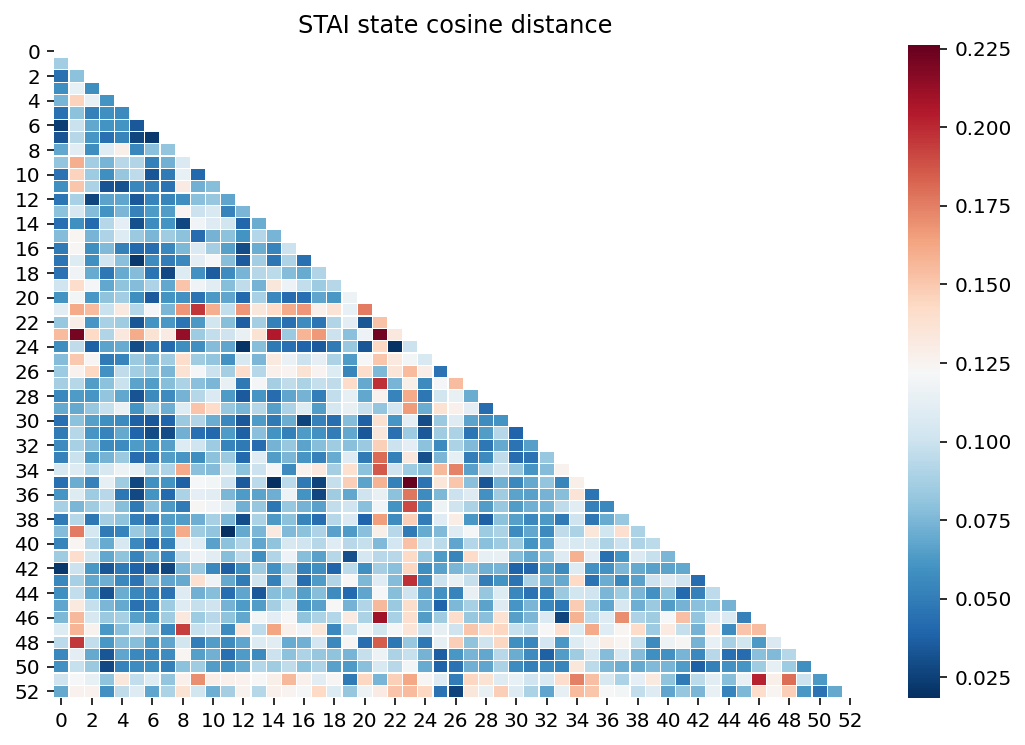

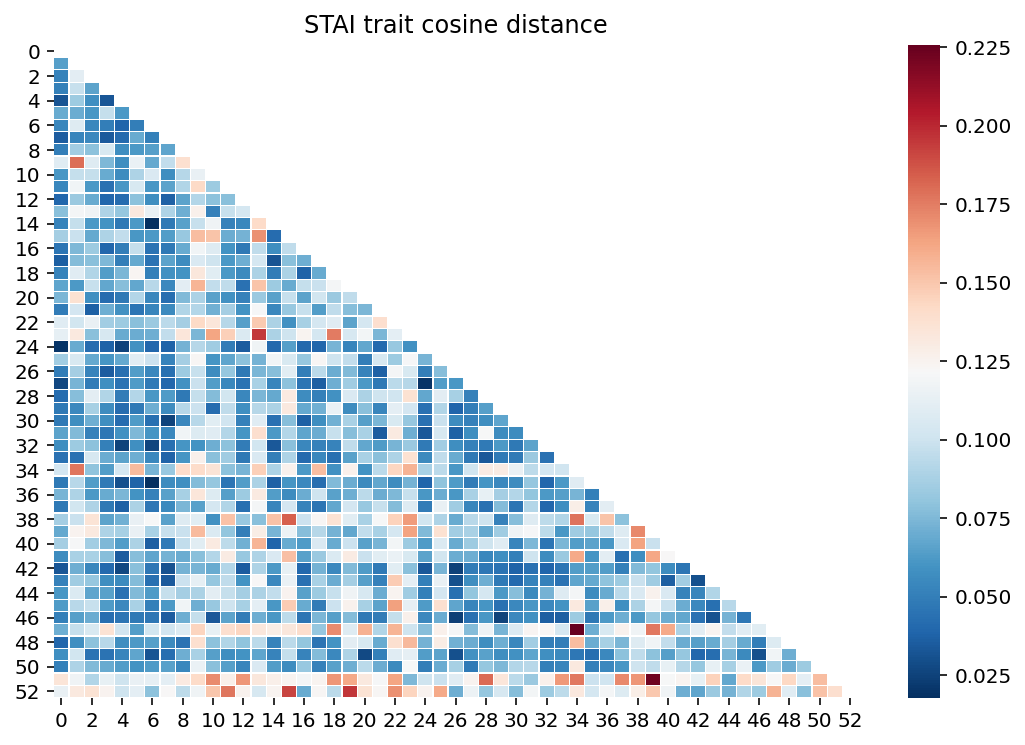

In [14]:
# subscales
state = list(range(1,21))
trait = list(range(21,41))
sub_list=[state,trait]
sub_name=['state','trait']

subscales_isc("STAI", "cosine", sub_list, sub_name,draw=True)

# ISRSA

In [15]:
brain_list = ['Positive_pre','Negative_pre','Neutral_pre']

for brain_name in brain_list:
    single_ISRSA(brain_name,'STAI_state',50,'eucosine')
    single_ISRSA(brain_name,'STAI_trait',50,'eucosine')


100%|██████████| 50/50 [02:48<00:00,  3.38s/it]


# Figures and Tables

## Figure 1(A), Figure 2 and Table 1

### (1) Positive

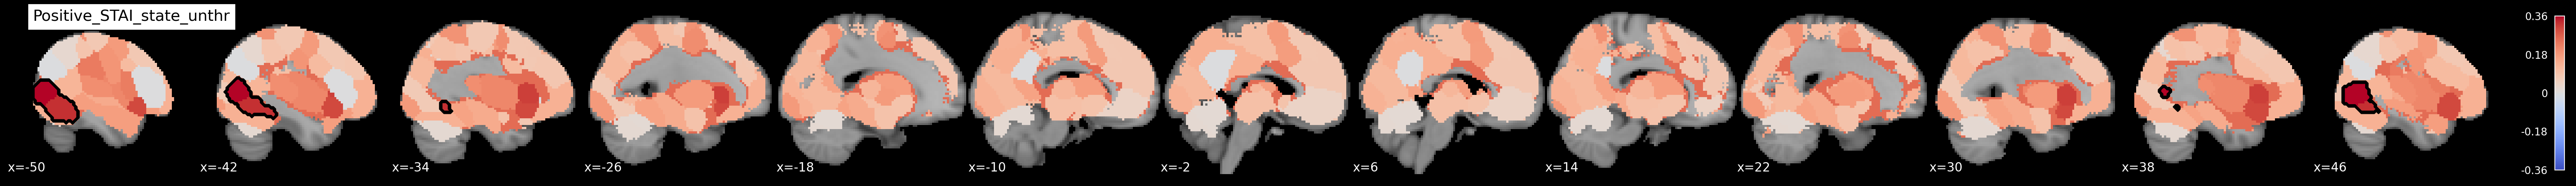

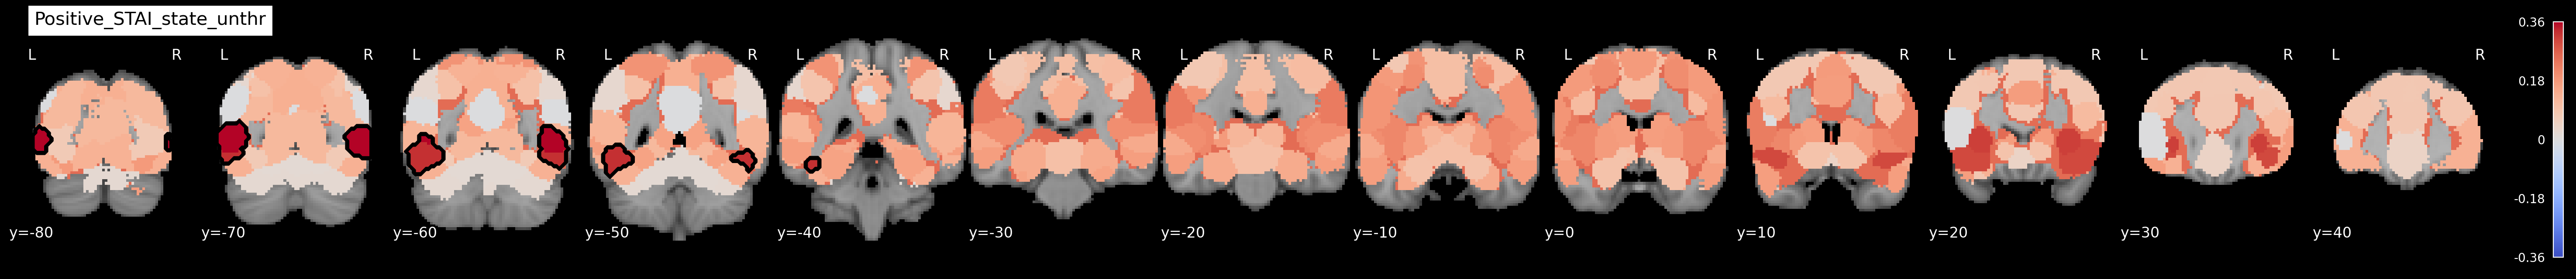

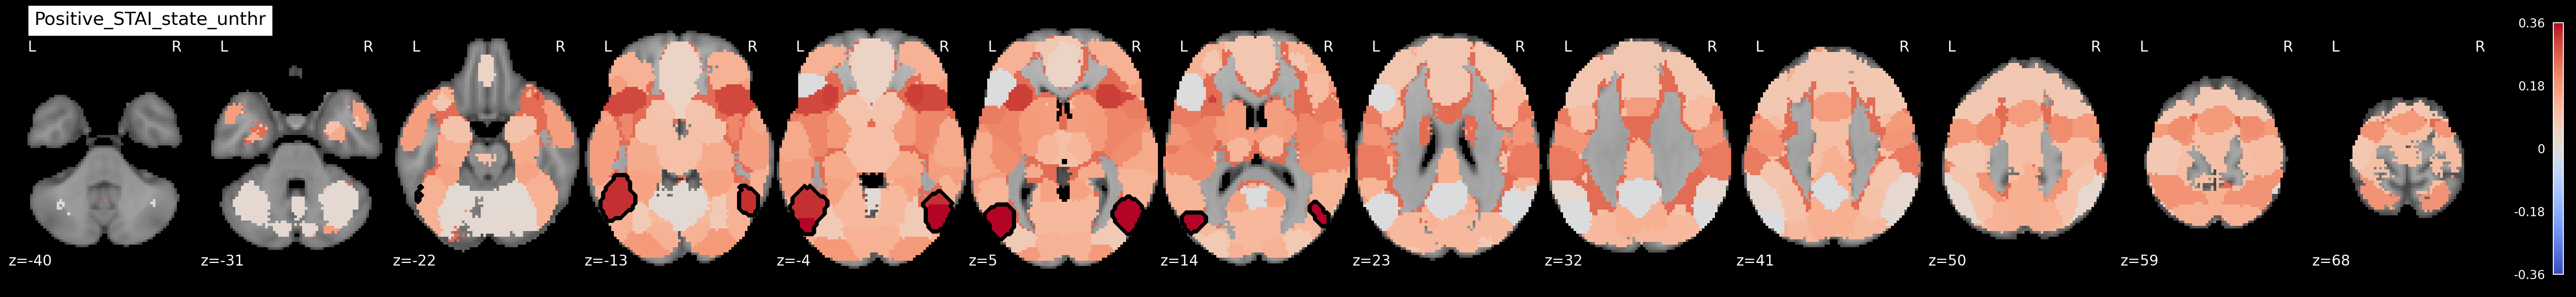

In [13]:
make_brainmap('Positive_pre', 'STAI_state', 50, 'eucosine', 'isrsa',vmax=0.36,method='FWE', draw_null=True)

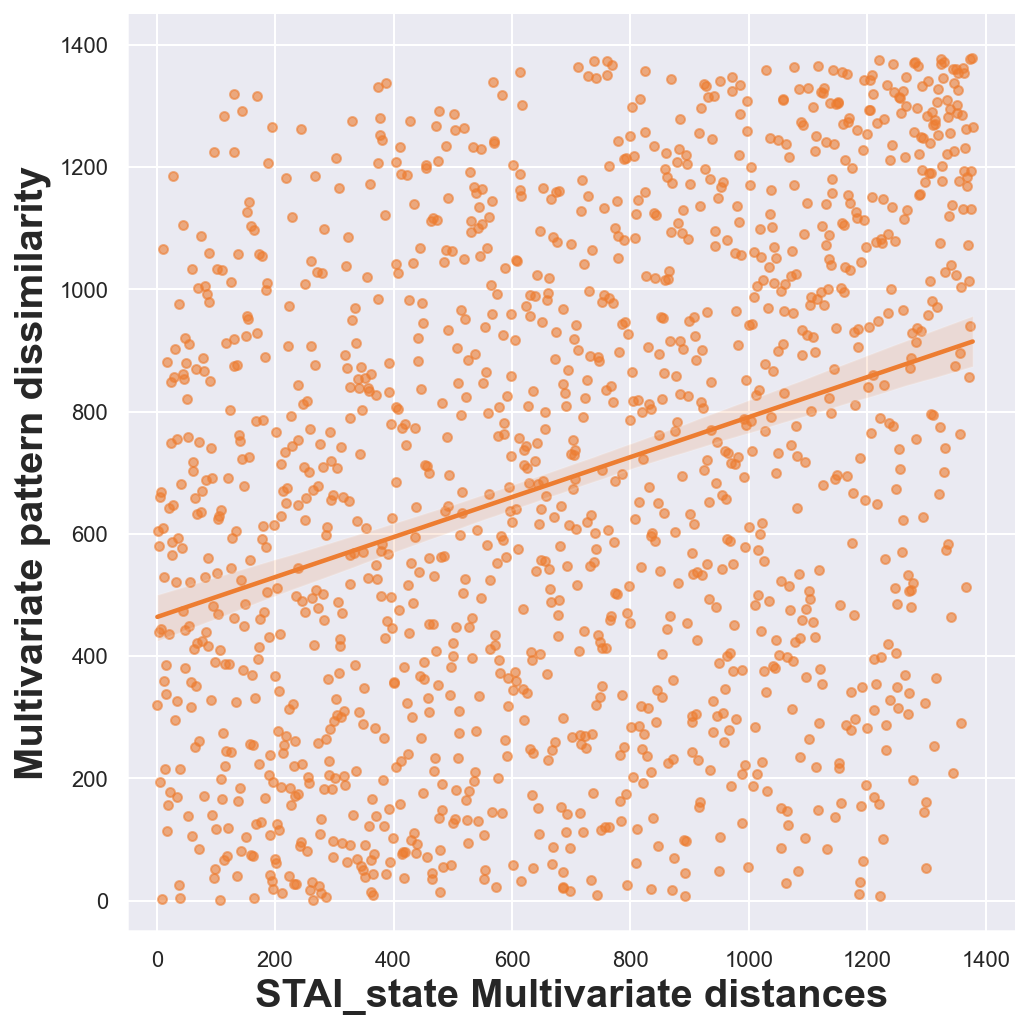

In [17]:
# fusiform gyrus
ISRSA_scatter_plots('Positive_pre','STAI_state',31,'eucosine',50, color='#ed7d31')

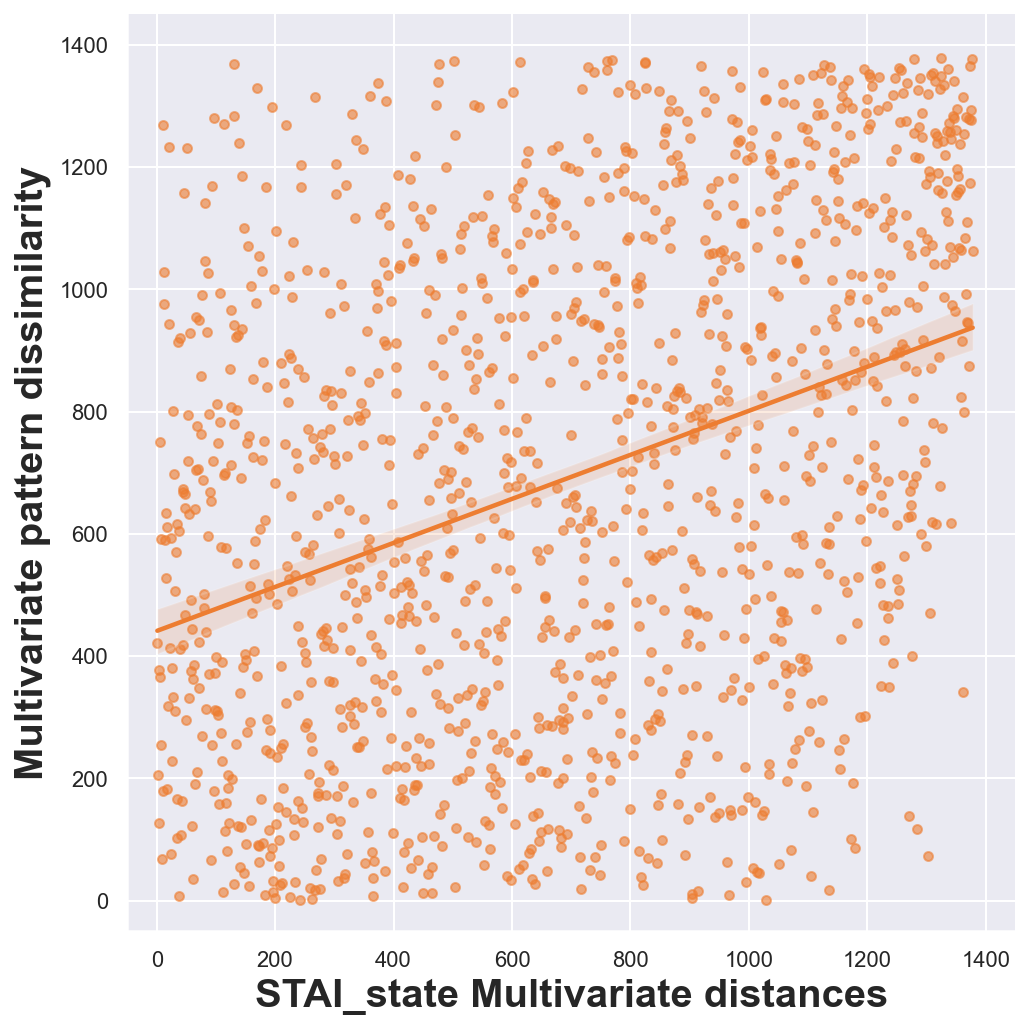

In [18]:
# area MT
ISRSA_scatter_plots('Positive_pre','STAI_state',46,'eucosine',50, color='#ed7d31')

### (2) Negative

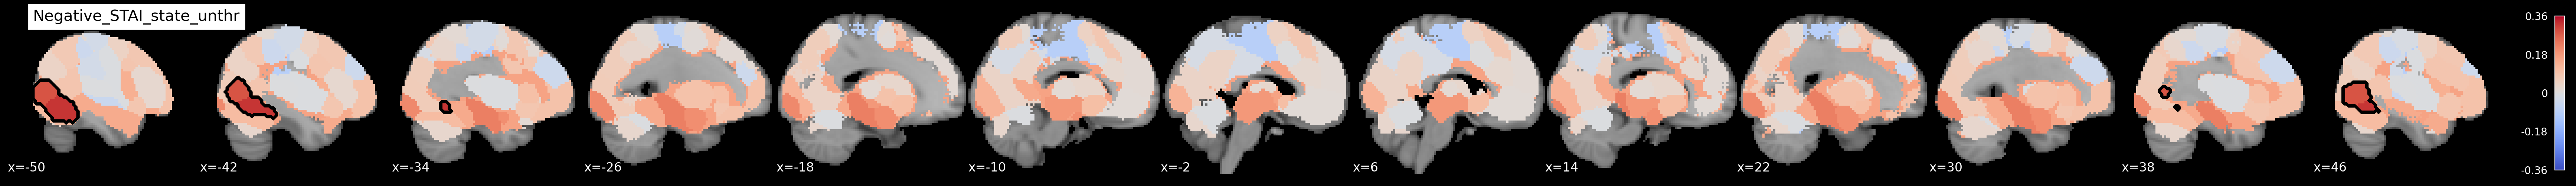

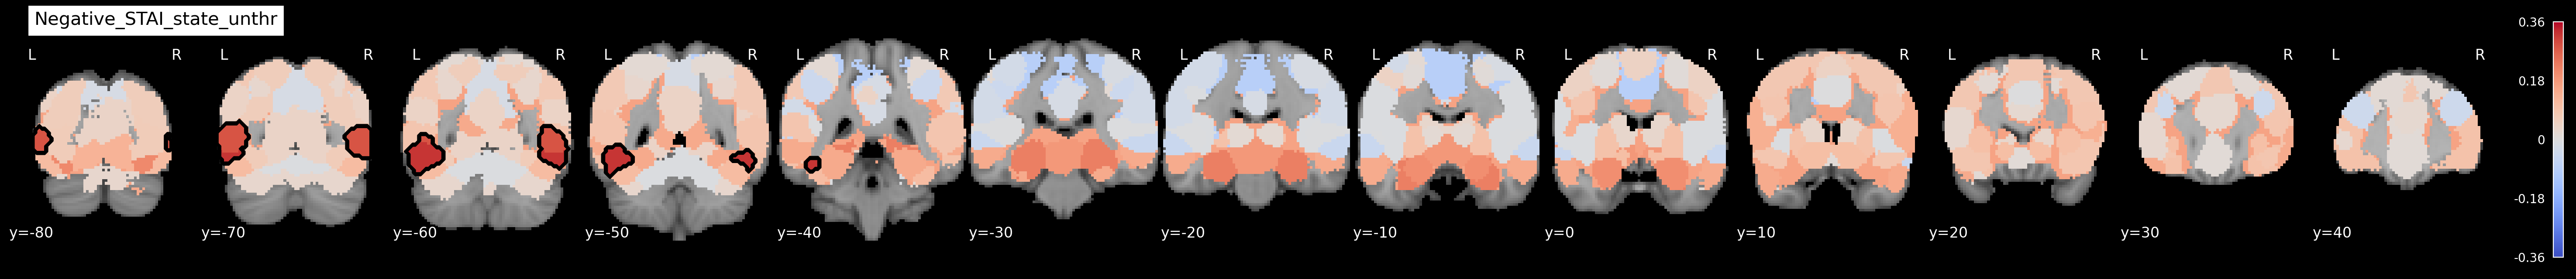

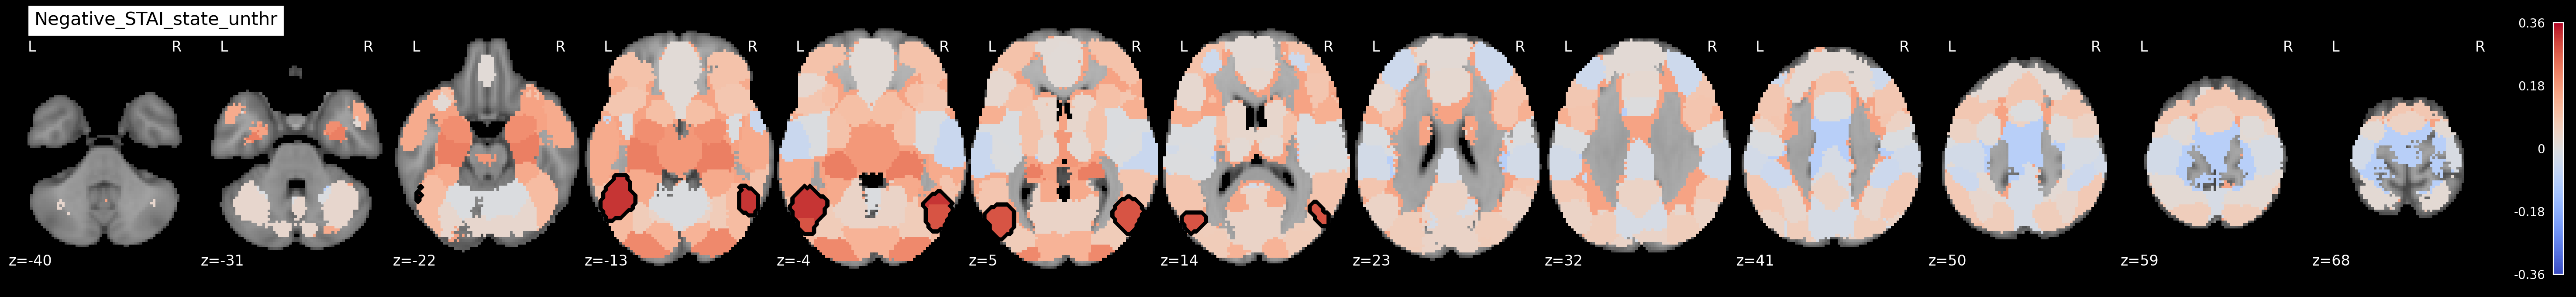

In [14]:
make_brainmap('Negative_pre', 'STAI_state', 50, 'eucosine', 'isrsa',vmax=0.36,method='FWE', draw_null=True)

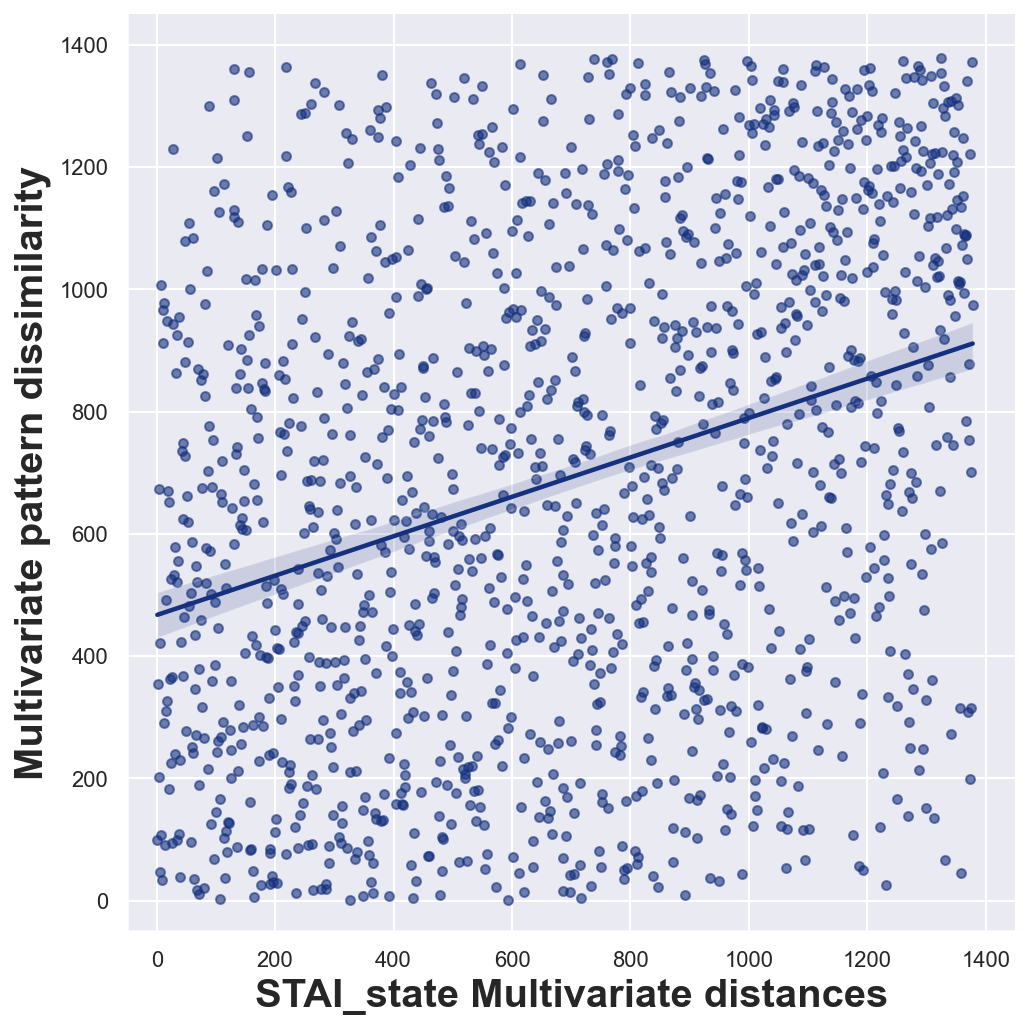

In [20]:
# fusiform gyrus
ISRSA_scatter_plots('Negative_pre','STAI_state',31,'eucosine',50, color='#15317E')

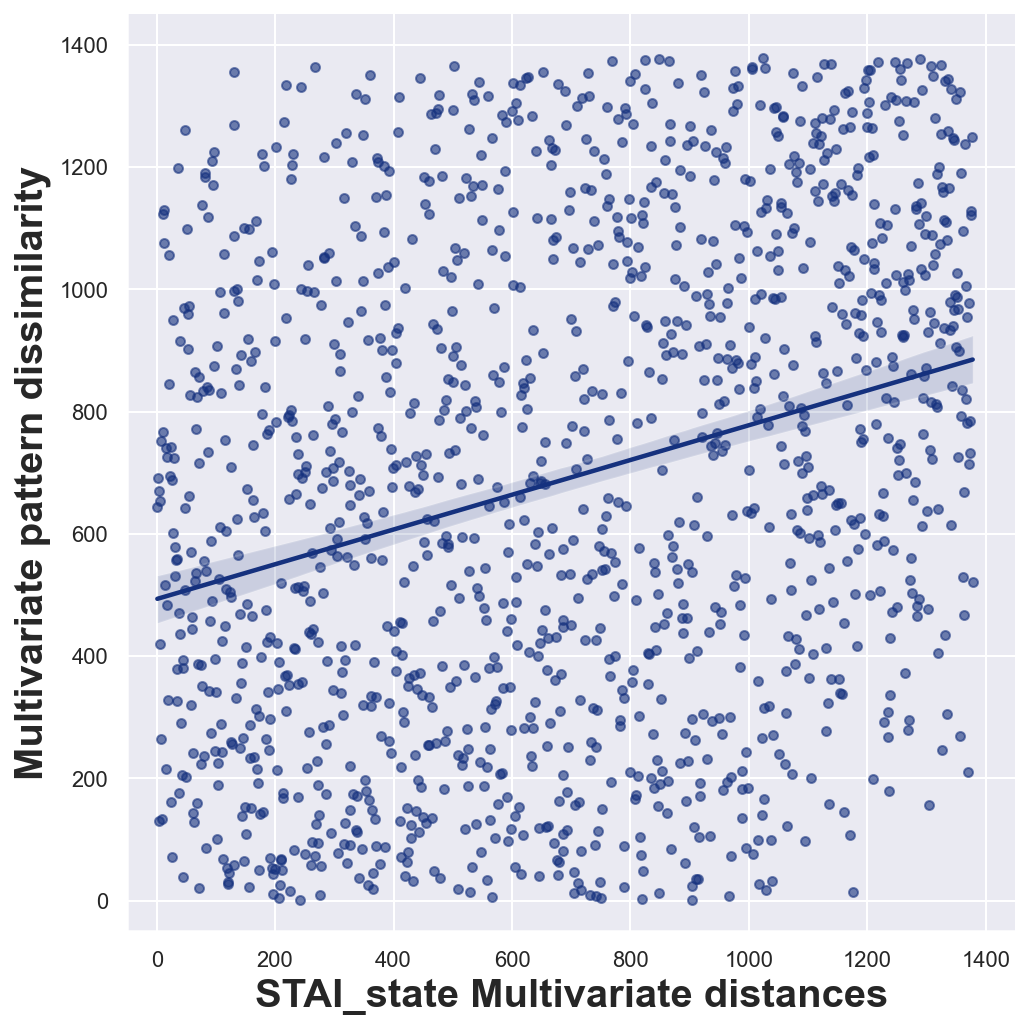

In [21]:
# area MT
ISRSA_scatter_plots('Negative_pre','STAI_state',46,'eucosine',50, color='#15317E')

### (3) Neutral

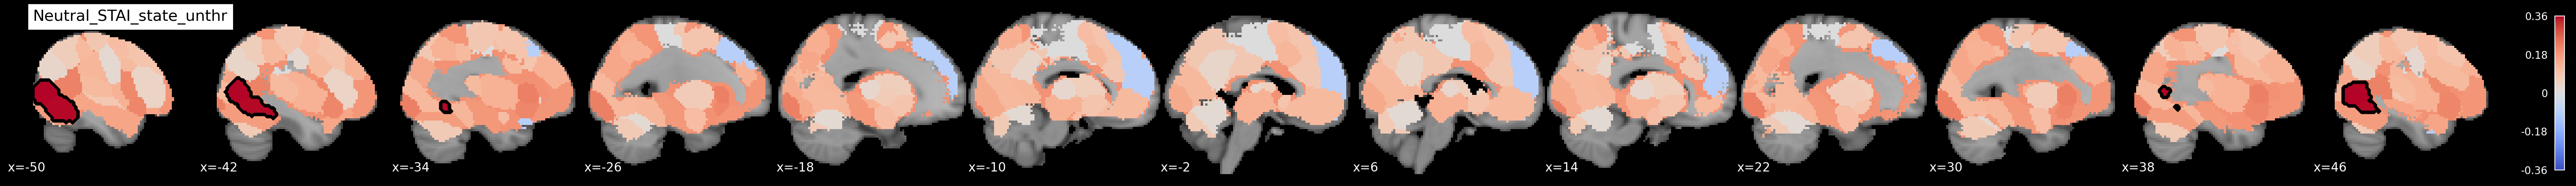

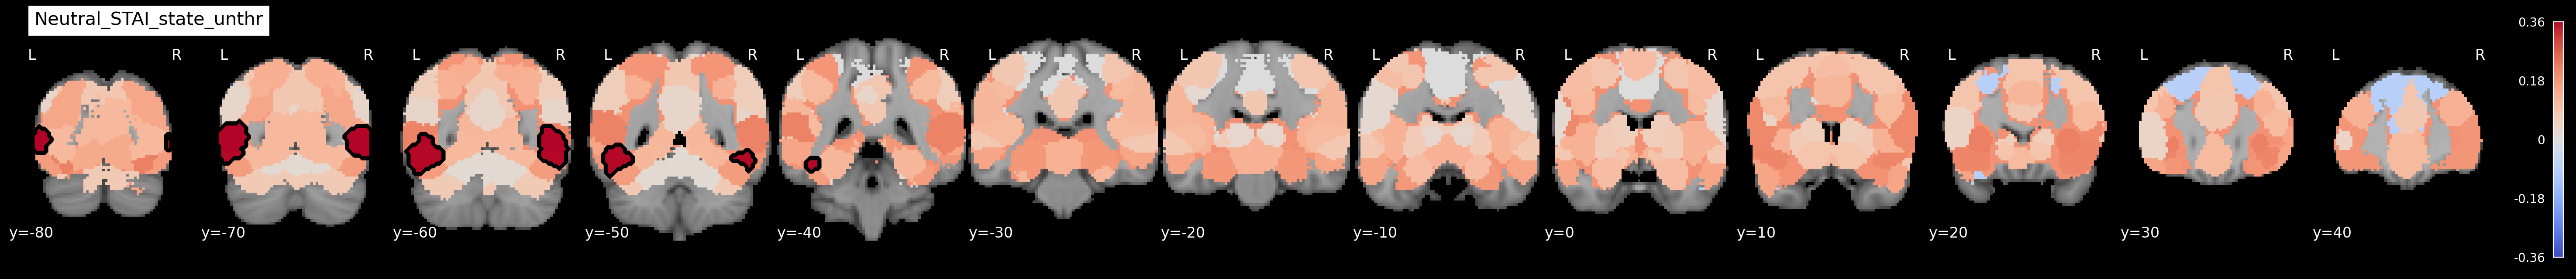

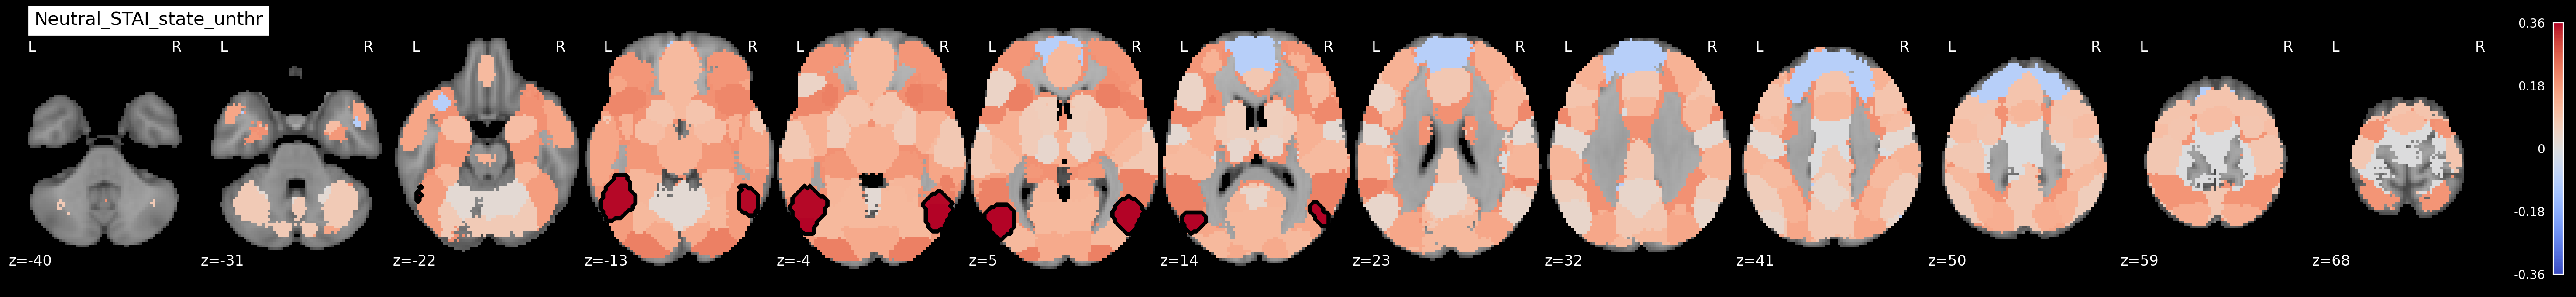

In [15]:
make_brainmap('Neutral_pre', 'STAI_state', 50, 'eucosine', 'isrsa',vmax=0.36,method='FWE', draw_null=True)

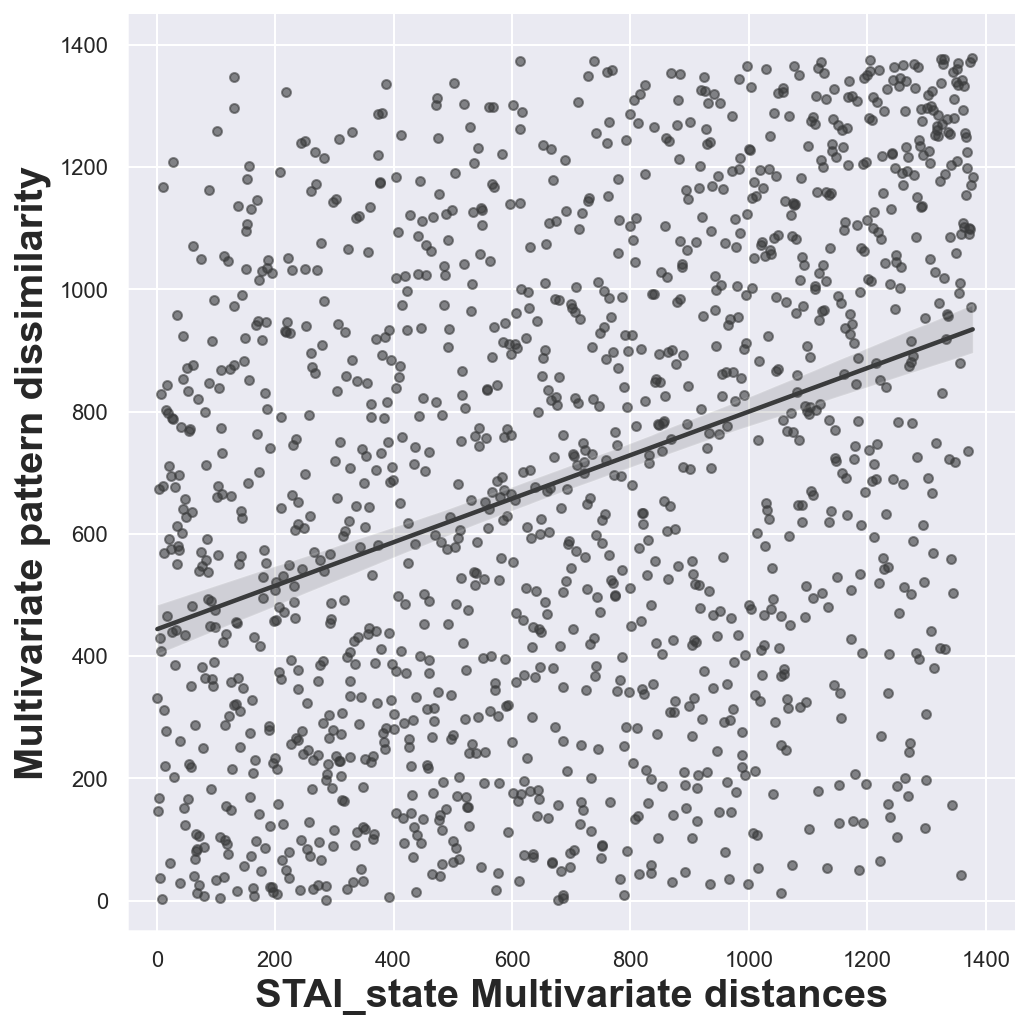

In [23]:
# fusiform gyrus
ISRSA_scatter_plots('Neutral_pre','STAI_state',31,'eucosine',50, color='#3A3B3C')

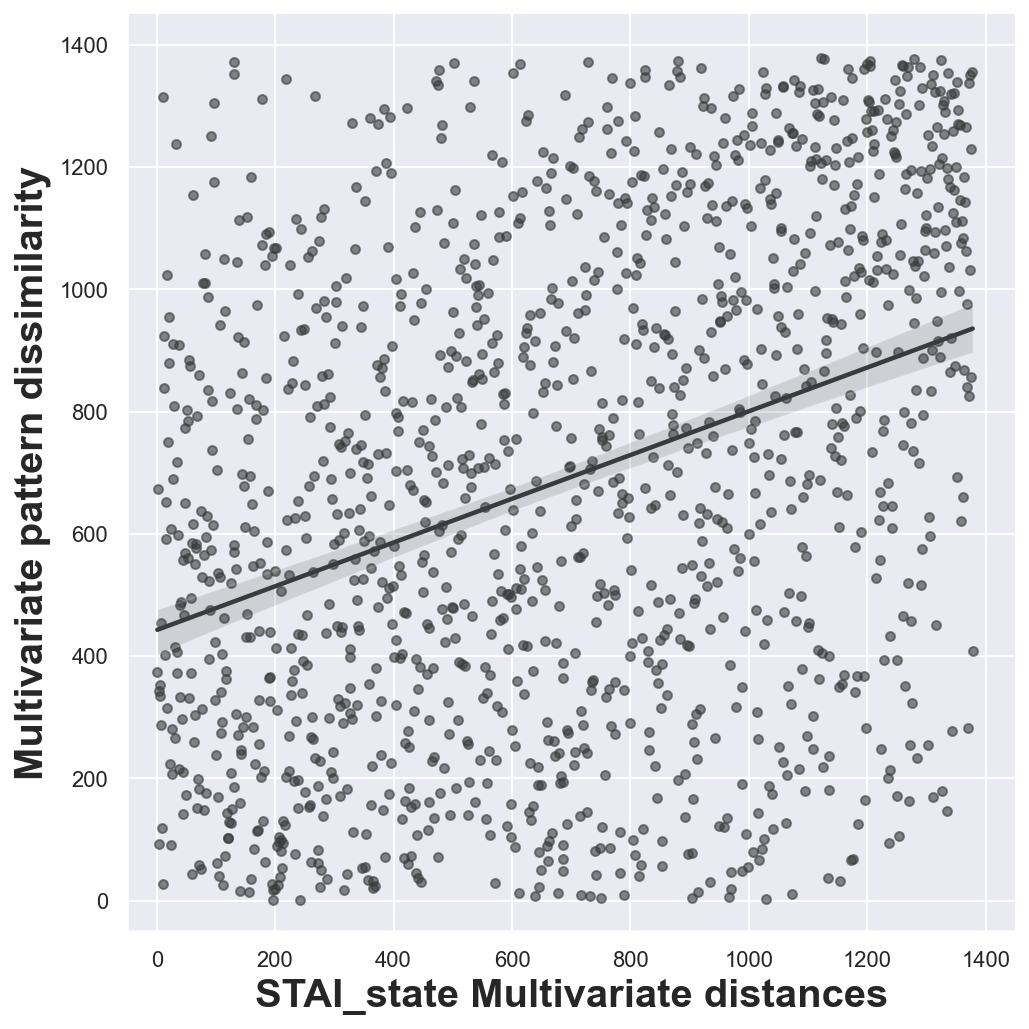

In [24]:
# area MT
ISRSA_scatter_plots('Neutral_pre','STAI_state',46,'eucosine',50, color='#3A3B3C')

## Figure 1(B) and Table 1

### (1) Positive

100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


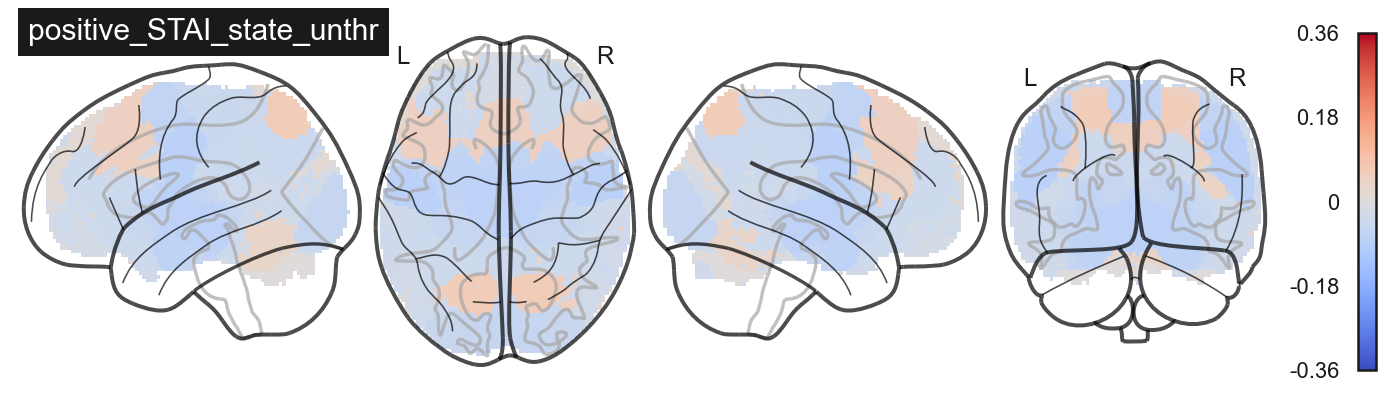

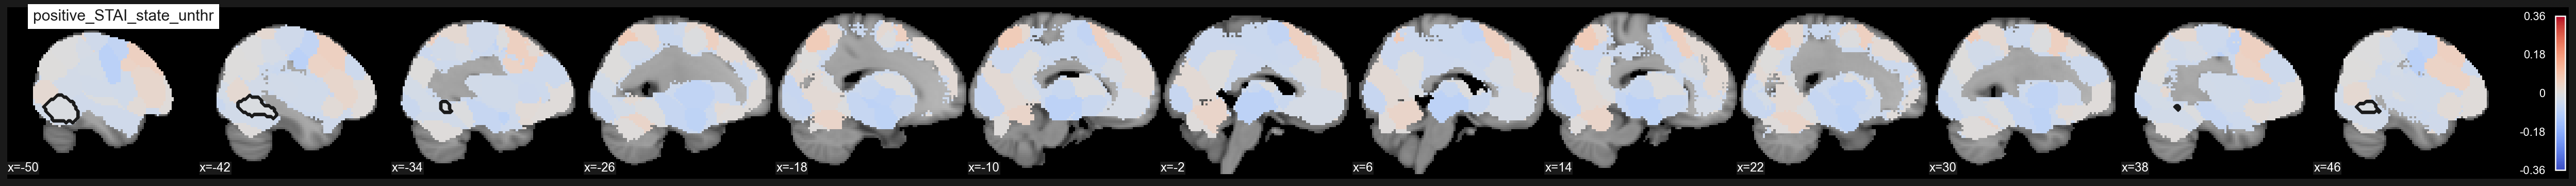

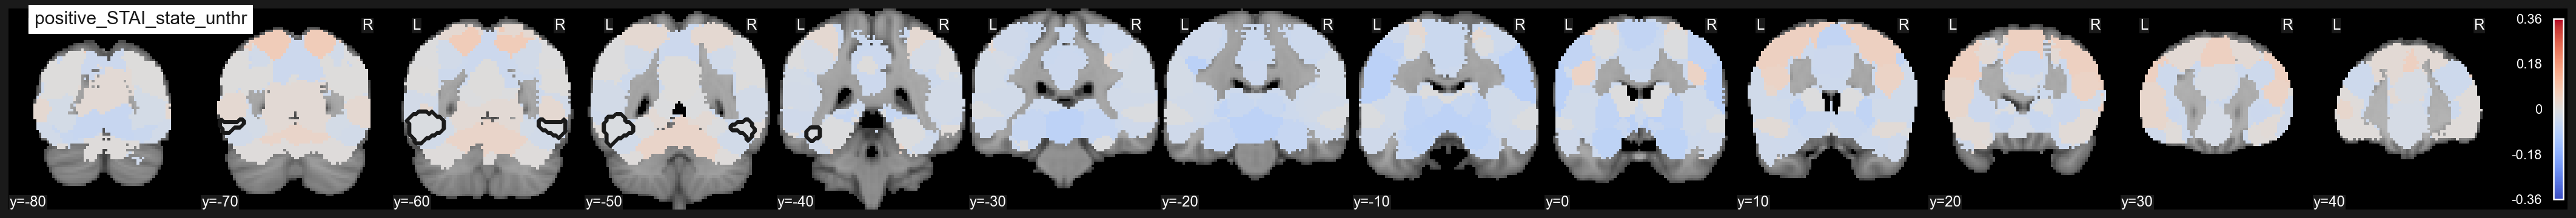

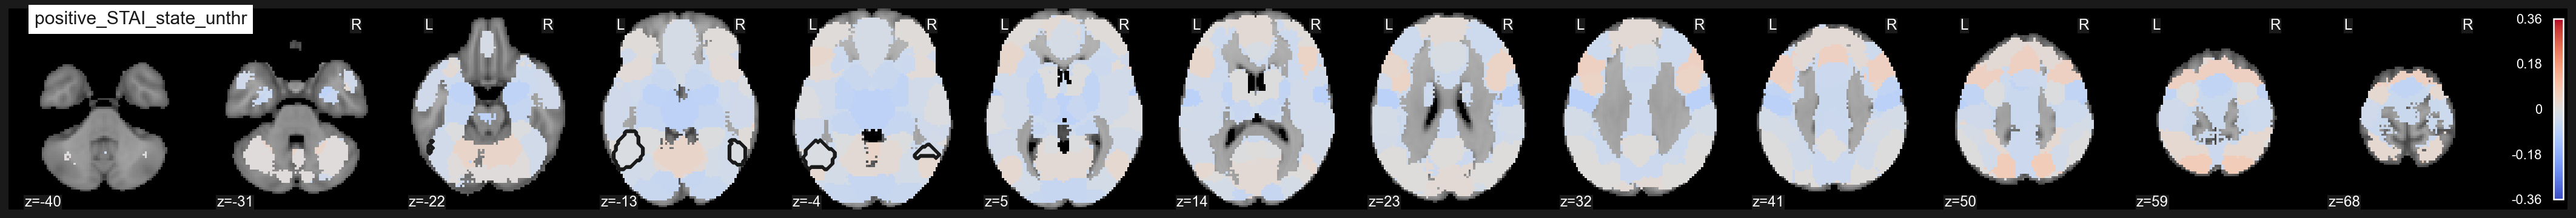

In [25]:
uni_ISRSA_wholeBrain('positive_pre', 'STAI_state', 50, vmax=0.36, draw_null=True)

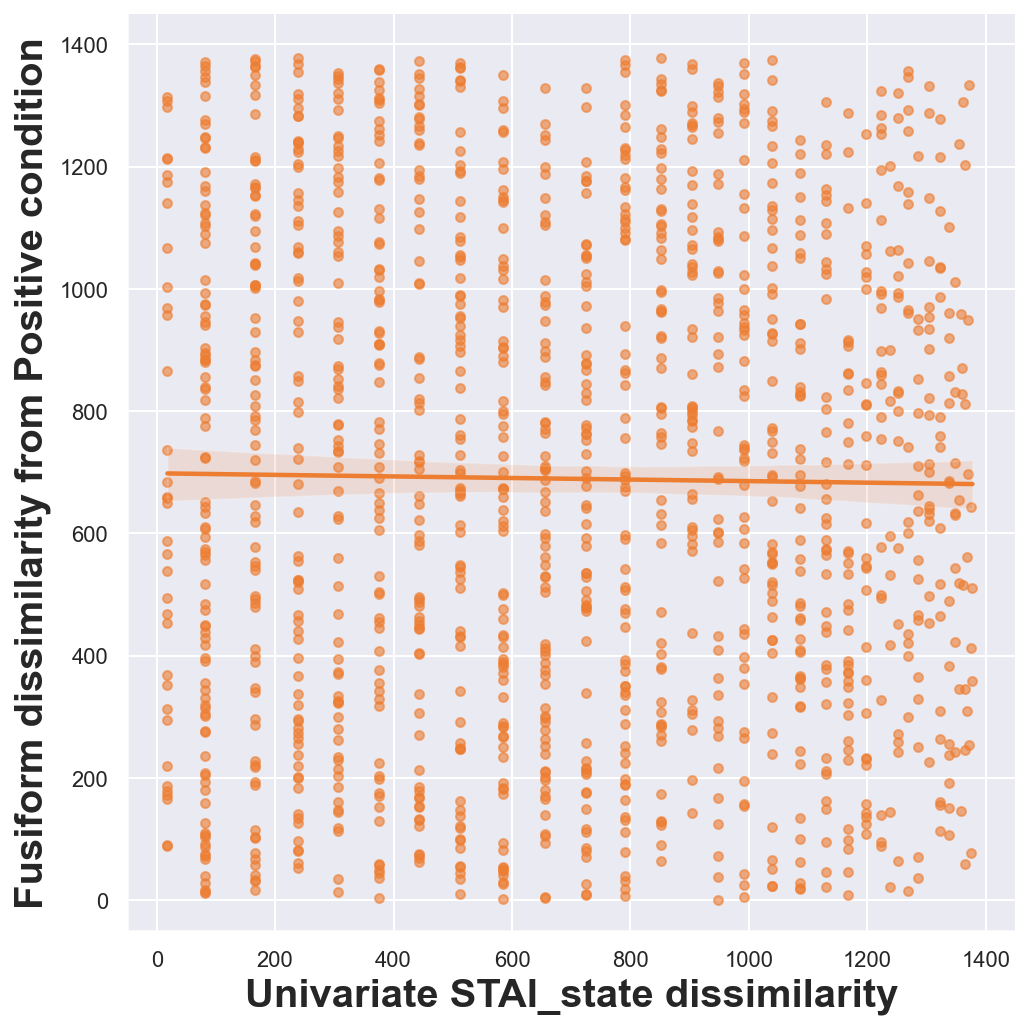

In [26]:
# fusiform gyrus
uni_ISRSA_specific('Positive_pre', 'STAI_state', 50, 31, color='#ed7d31')

### (2) Negative

100%|██████████| 50/50 [02:47<00:00,  3.35s/it]


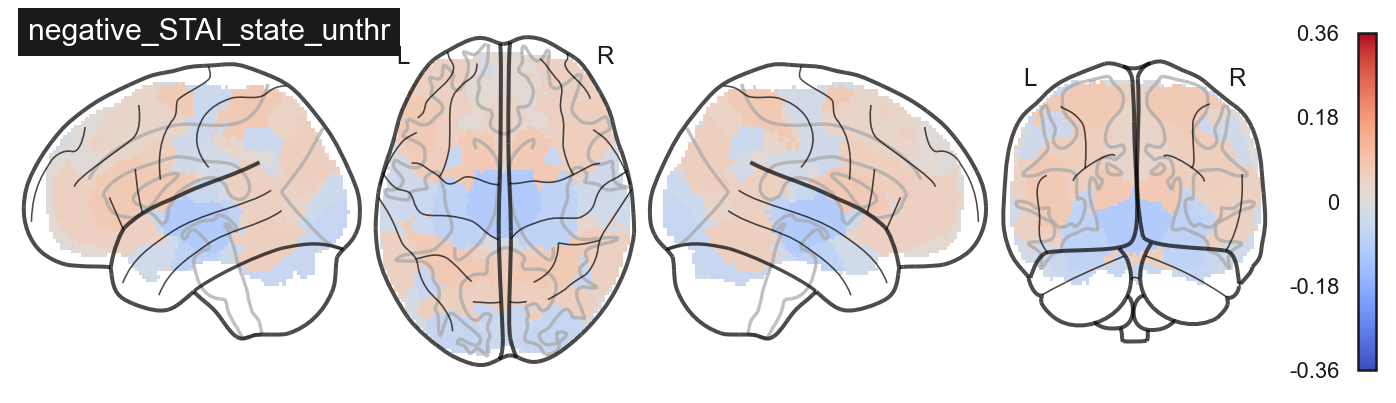

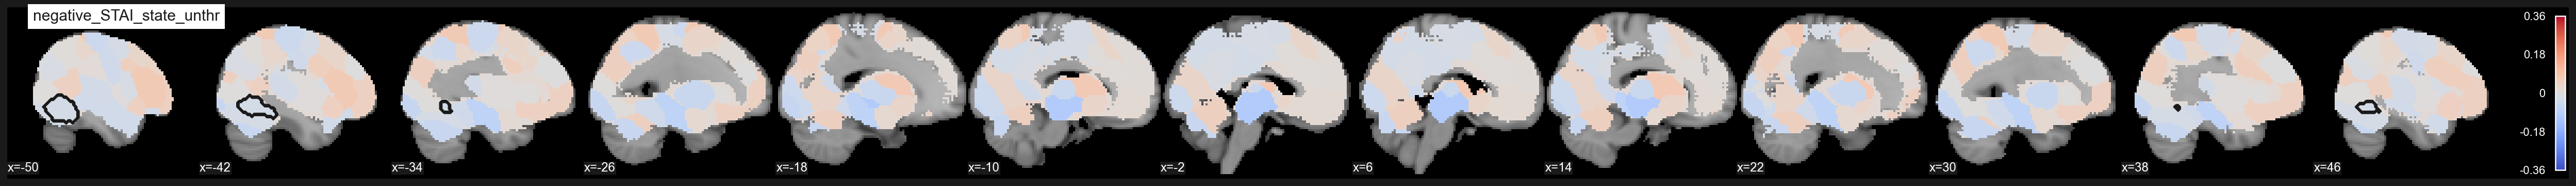

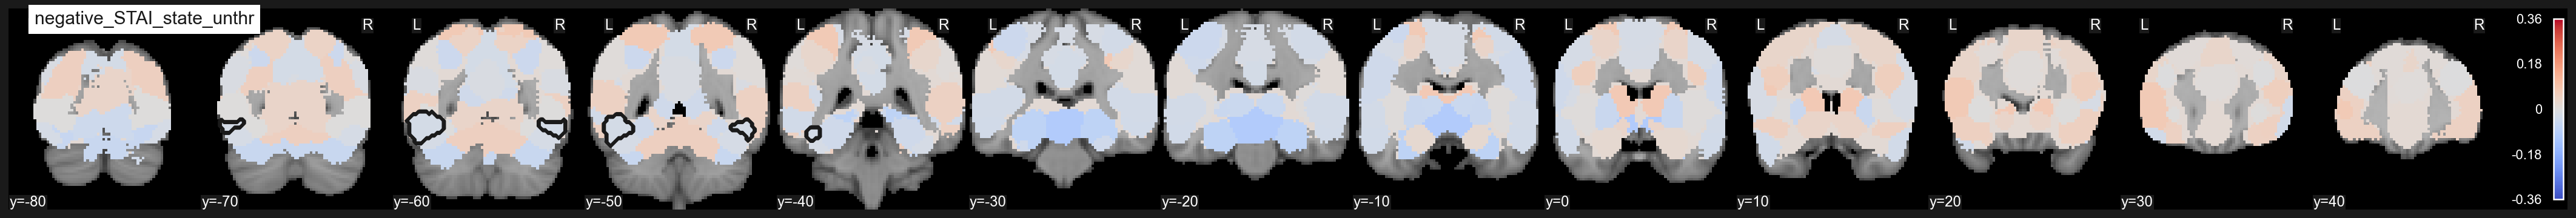

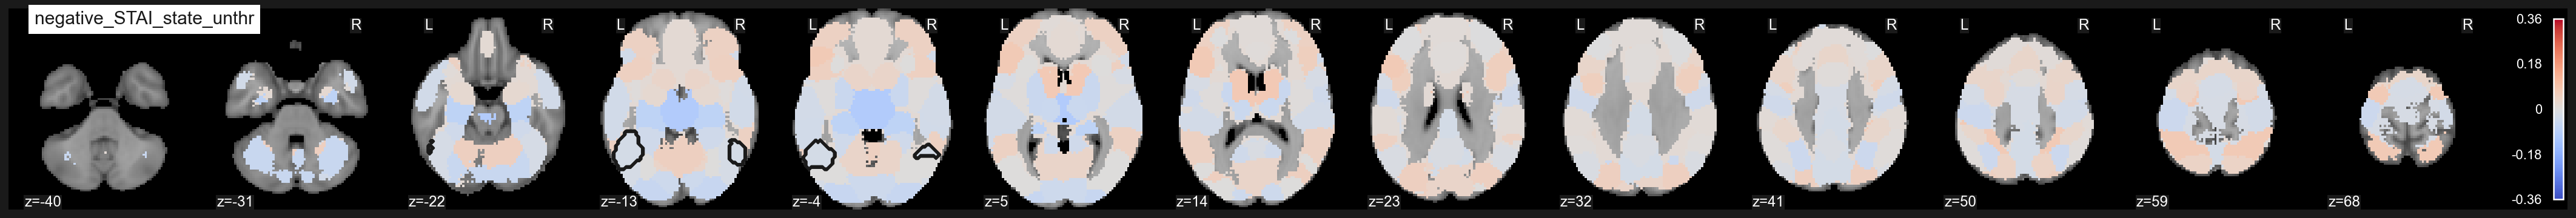

In [27]:
uni_ISRSA_wholeBrain('negative_pre', 'STAI_state', 50, vmax=0.36, draw_null=True)

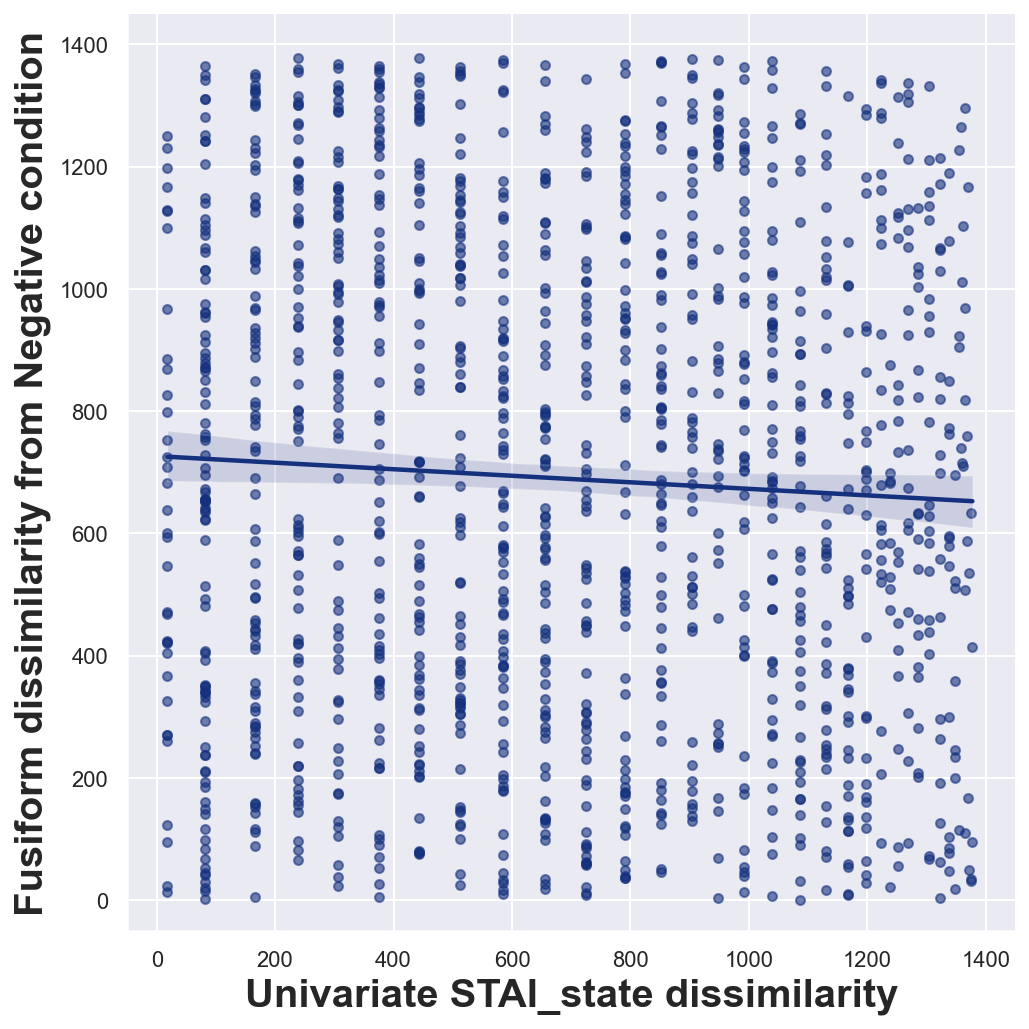

In [28]:
# fusiform gyrus
uni_ISRSA_specific('Negative_pre', 'STAI_state', 50, 31, color='#15317E')

### (3) Neutral

100%|██████████| 50/50 [02:54<00:00,  3.50s/it]


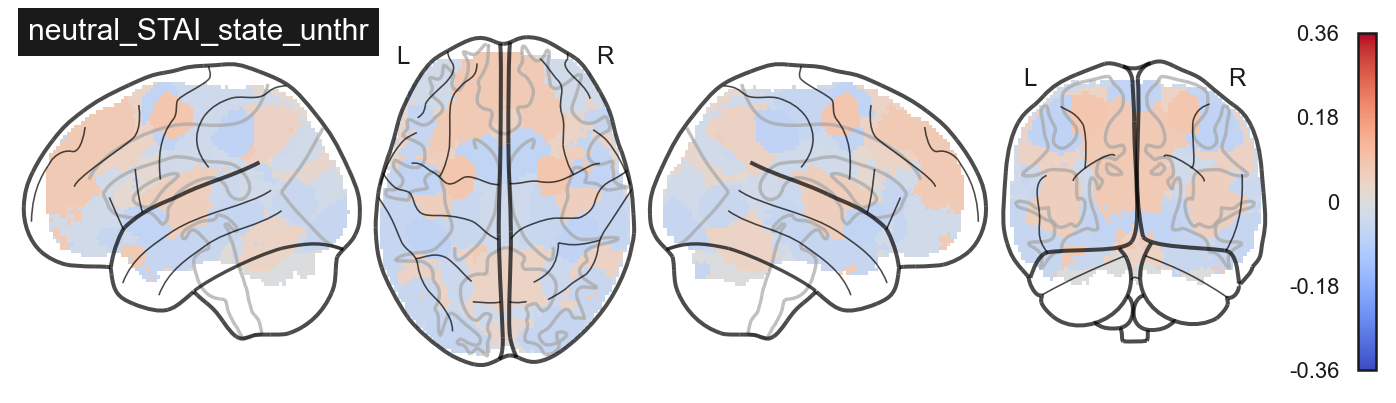

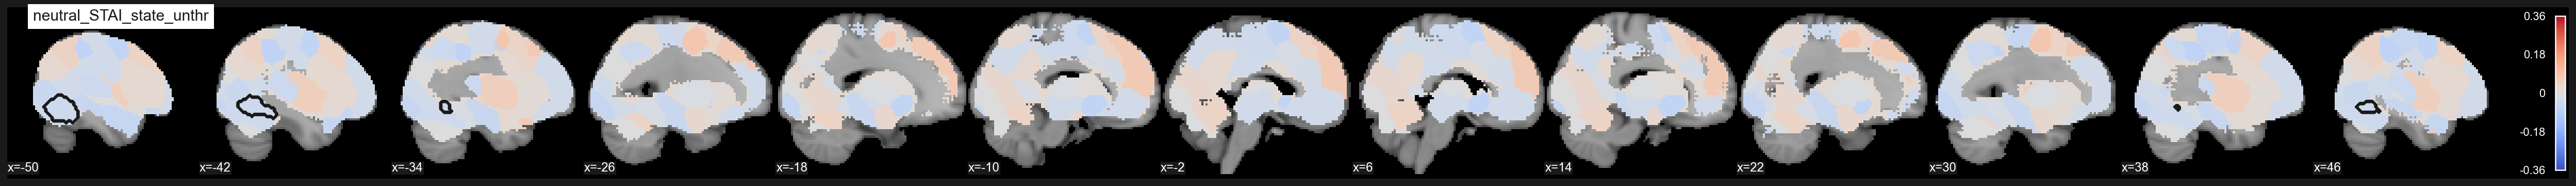

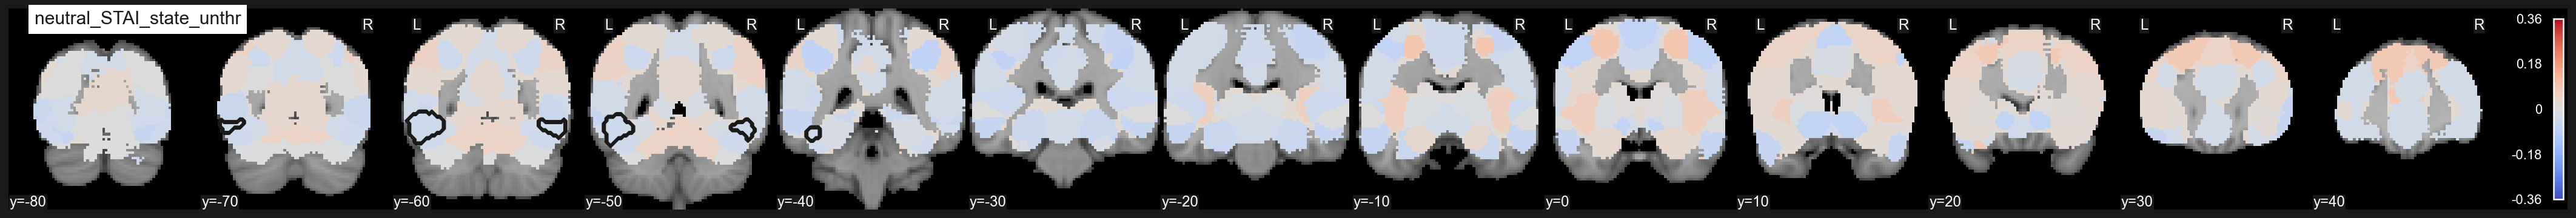

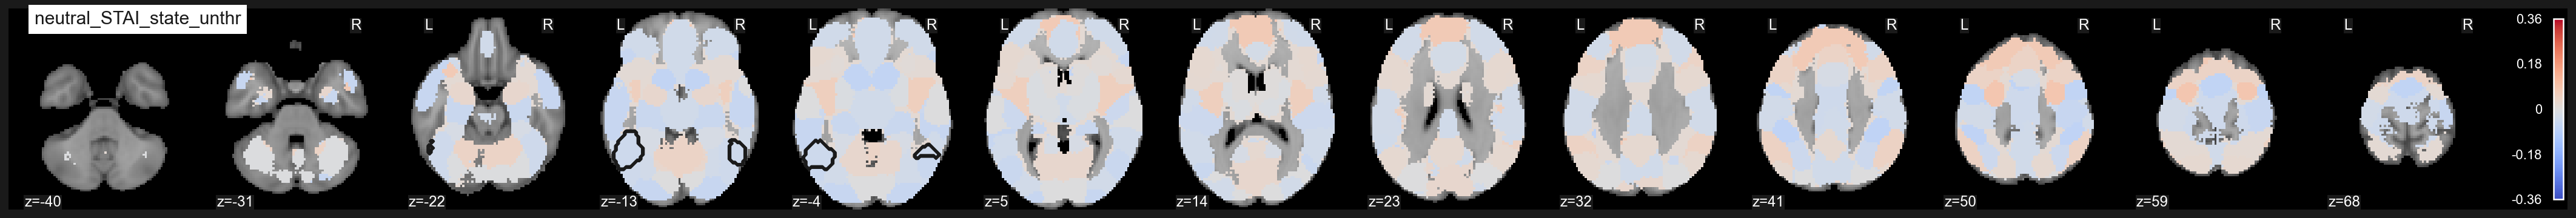

In [29]:
uni_ISRSA_wholeBrain('neutral_pre', 'STAI_state', 50, vmax=0.36, draw_null=True)

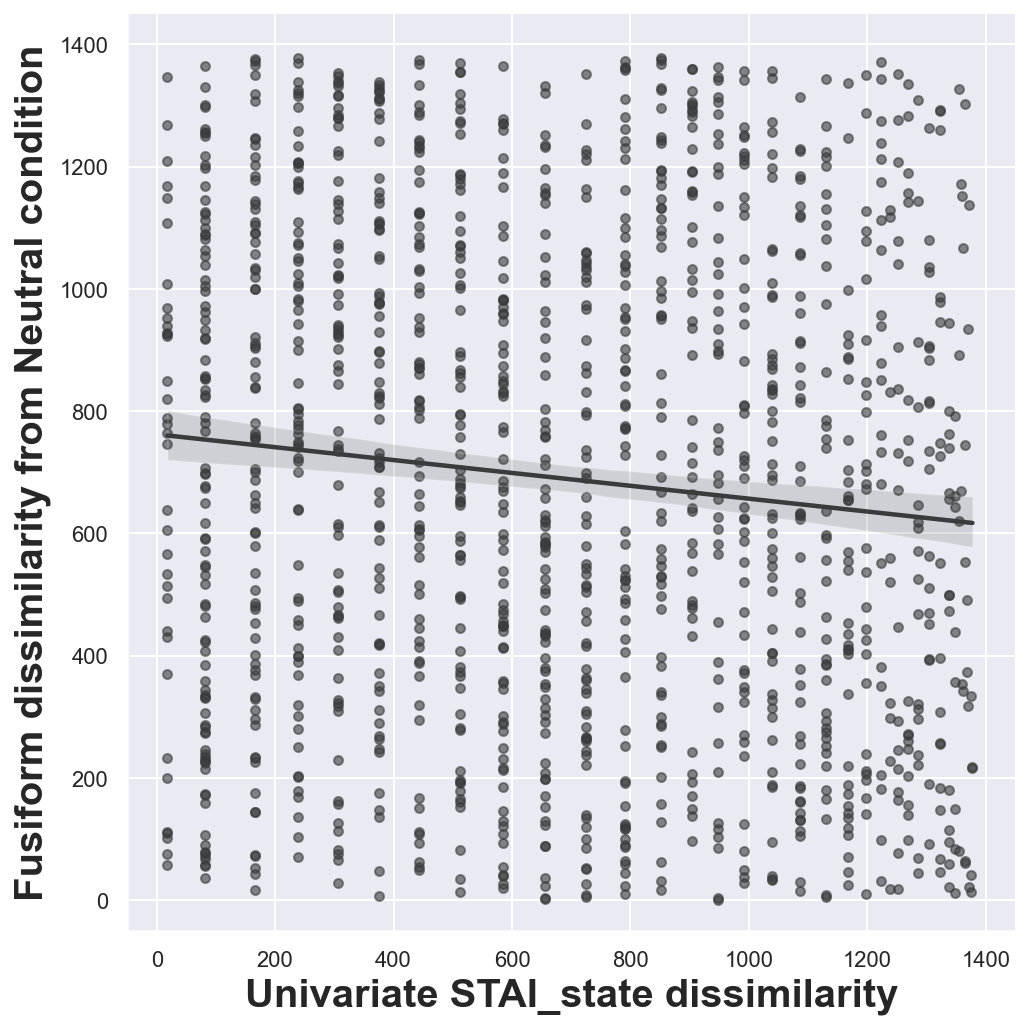

In [30]:
# fusiform gyrus
uni_ISRSA_specific('Neutral_pre', 'STAI_state', 50, 31, color='#3A3B3C')

## Figure S1 and Table S1

### (1) Positive

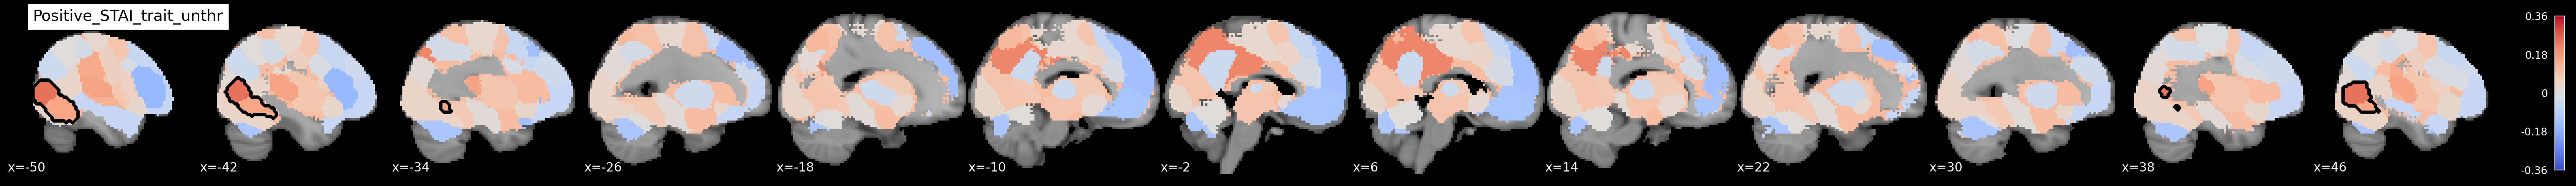

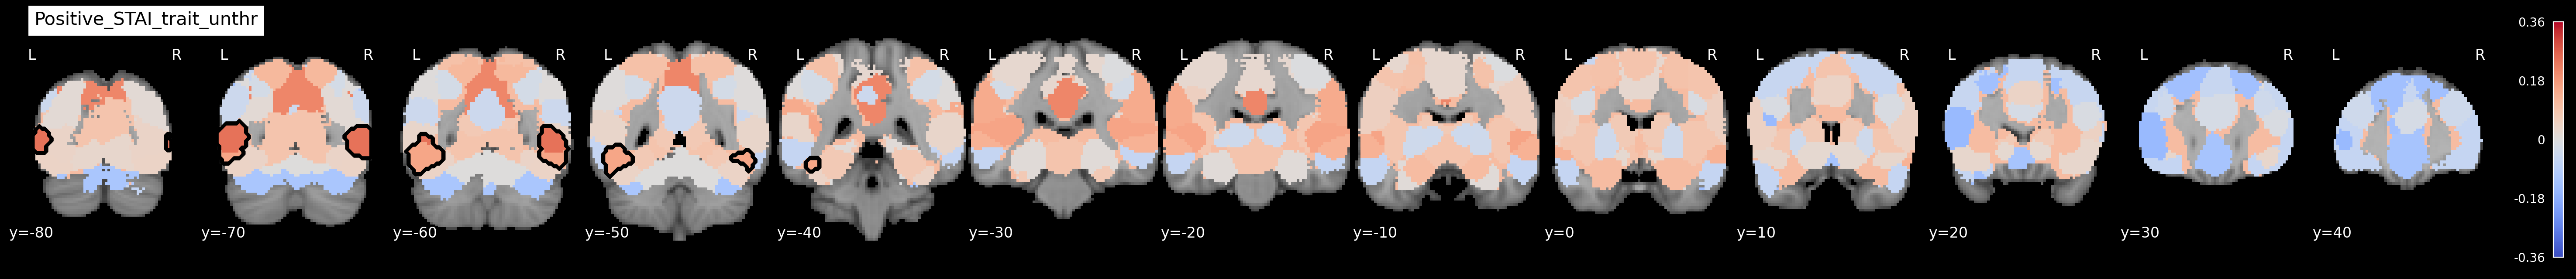

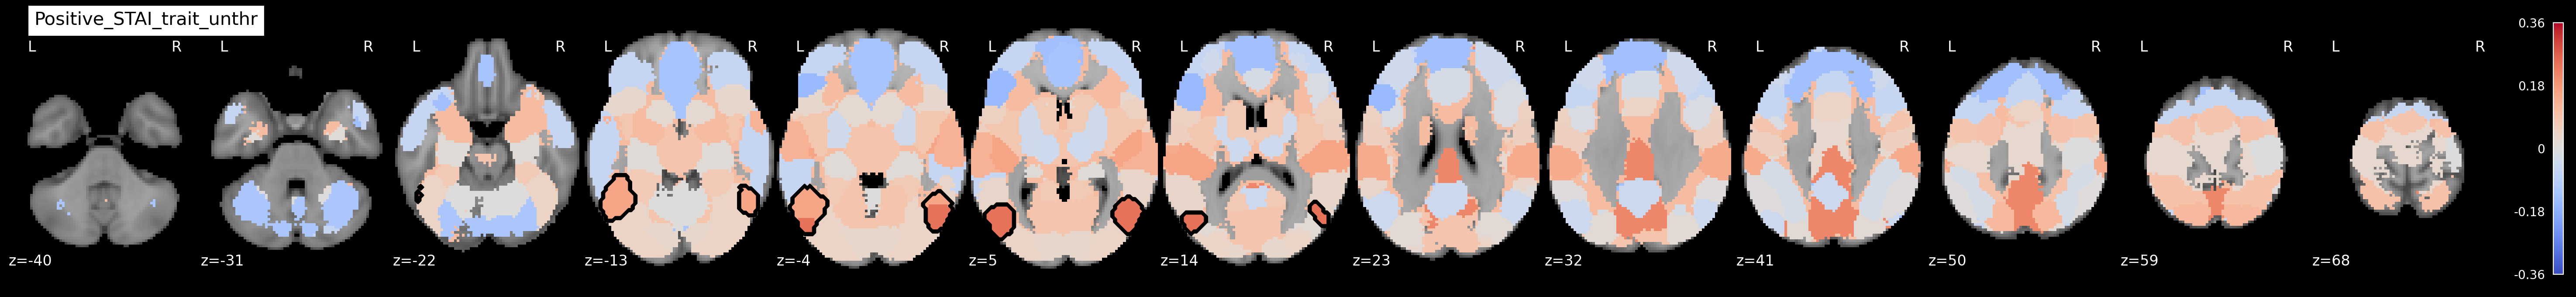

In [16]:
make_brainmap('Positive_pre', 'STAI_trait', 50, 'eucosine', 'isrsa',vmax=0.36,method='FWE', draw_null=True)

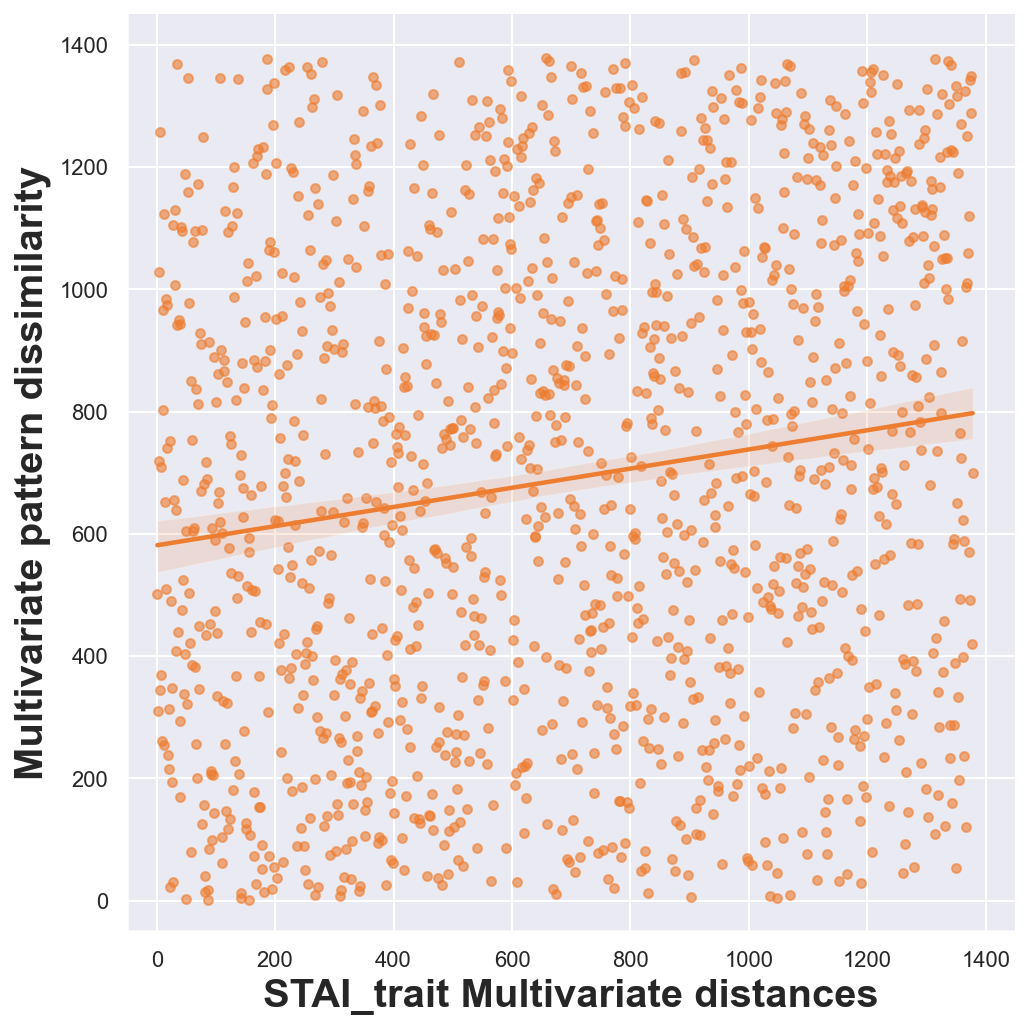

In [32]:
# fusiform gyrus
ISRSA_scatter_plots('Positive_pre','STAI_trait',31,'eucosine',50, color='#ed7d31')

### (2) Negative

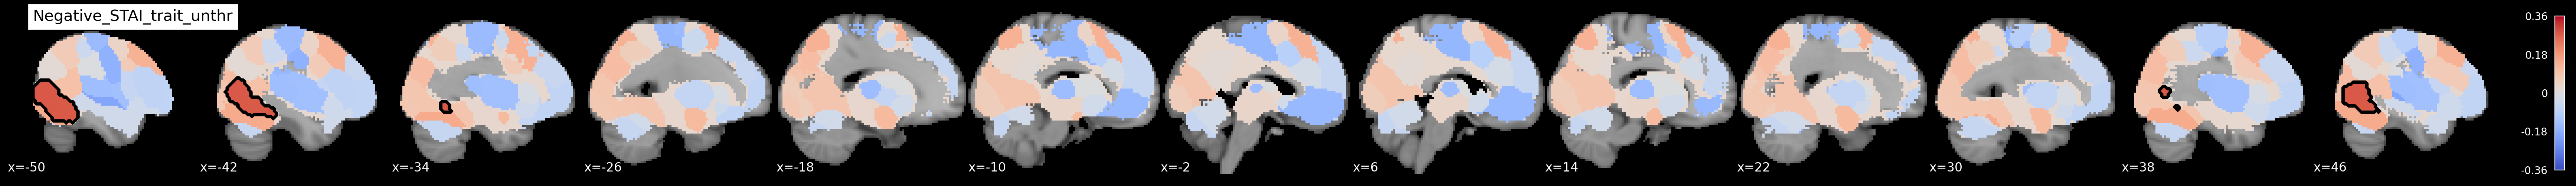

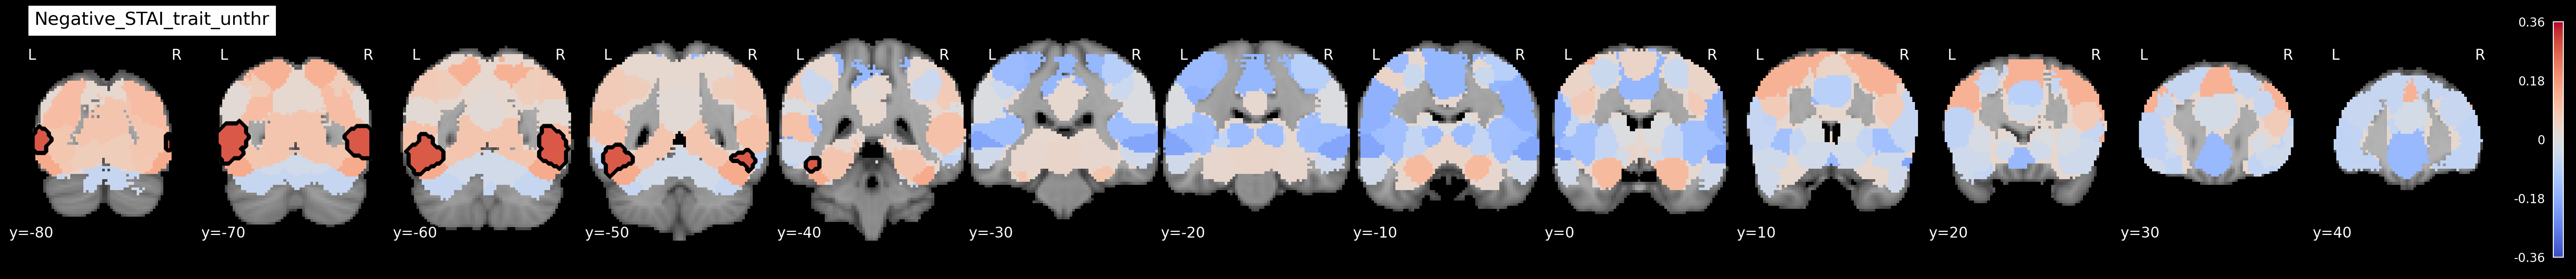

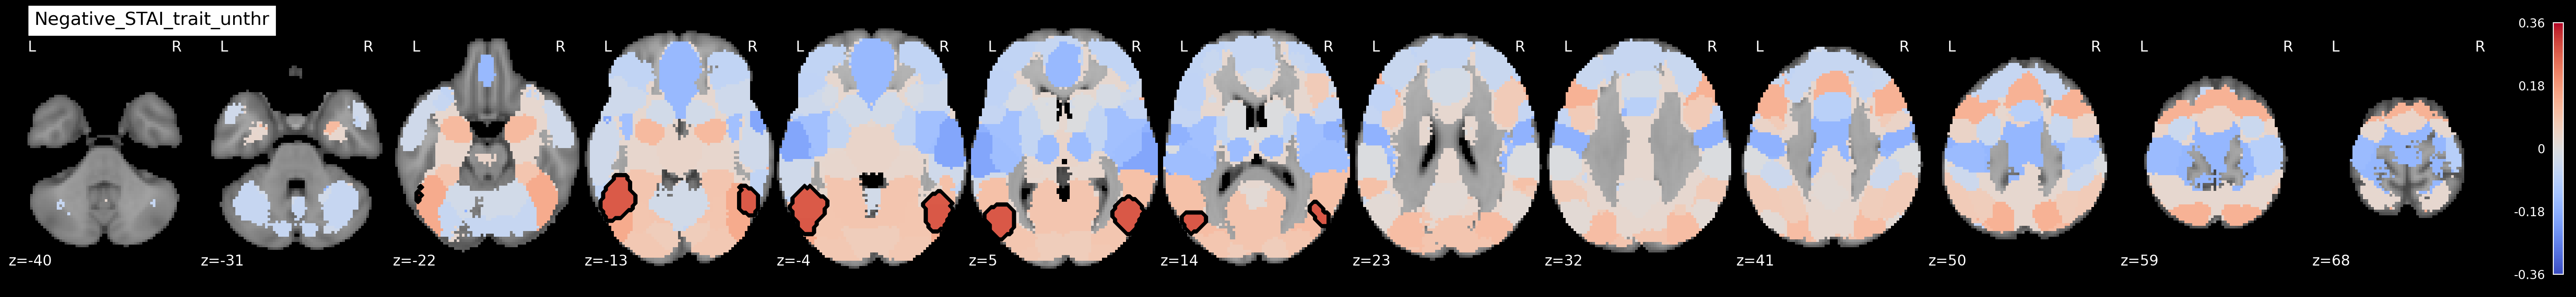

In [17]:
make_brainmap('Negative_pre', 'STAI_trait', 50, 'eucosine', 'isrsa',vmax=0.36,method='FWE', draw_null=True)

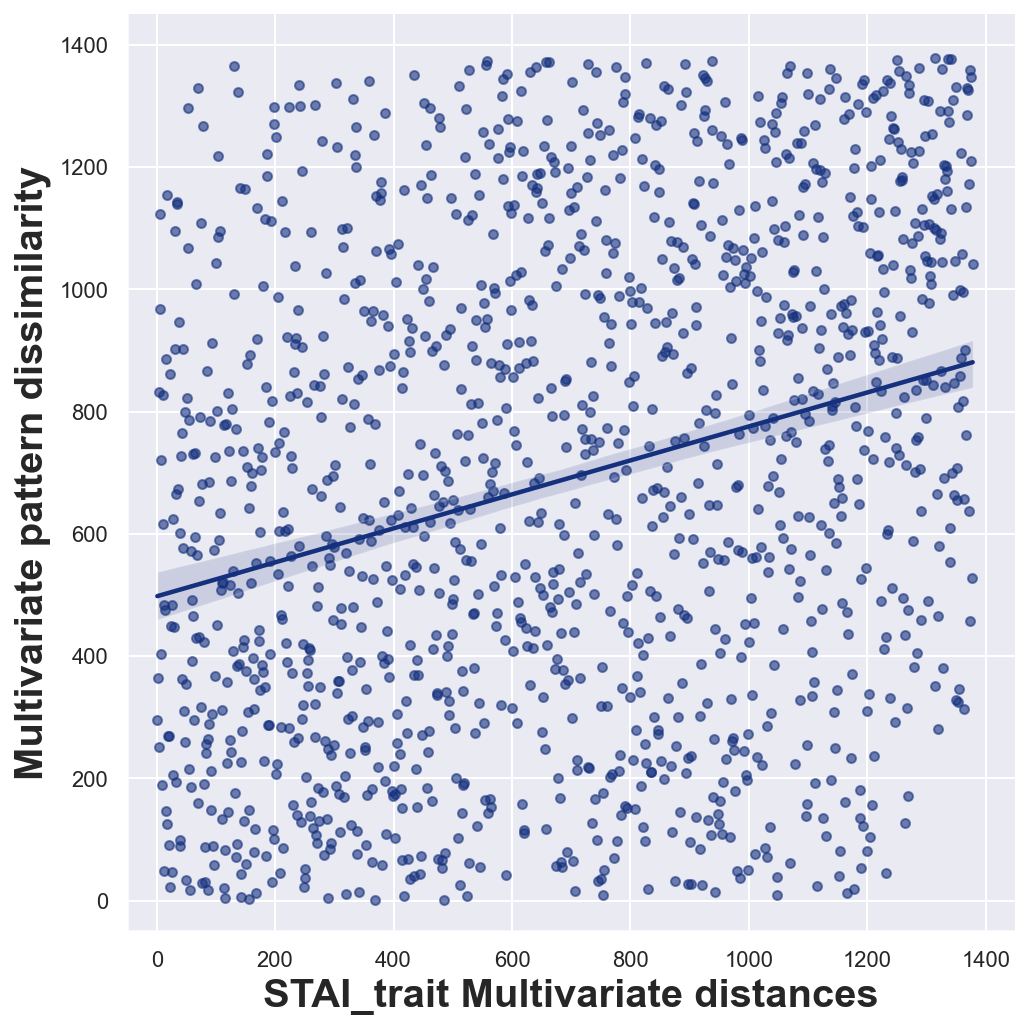

In [34]:
# fusiform gyrus
ISRSA_scatter_plots('Negative_pre','STAI_trait',31,'eucosine',50, color='#15317E')

### (3) Neutral

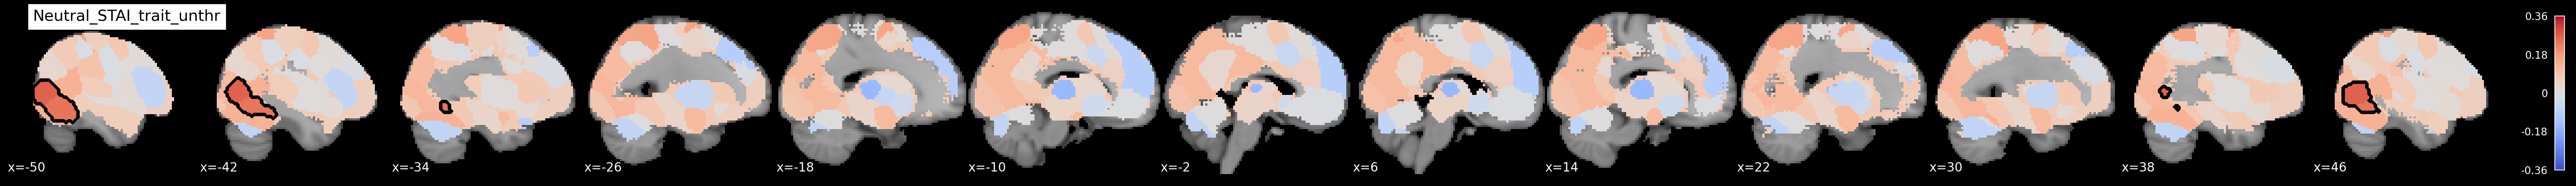

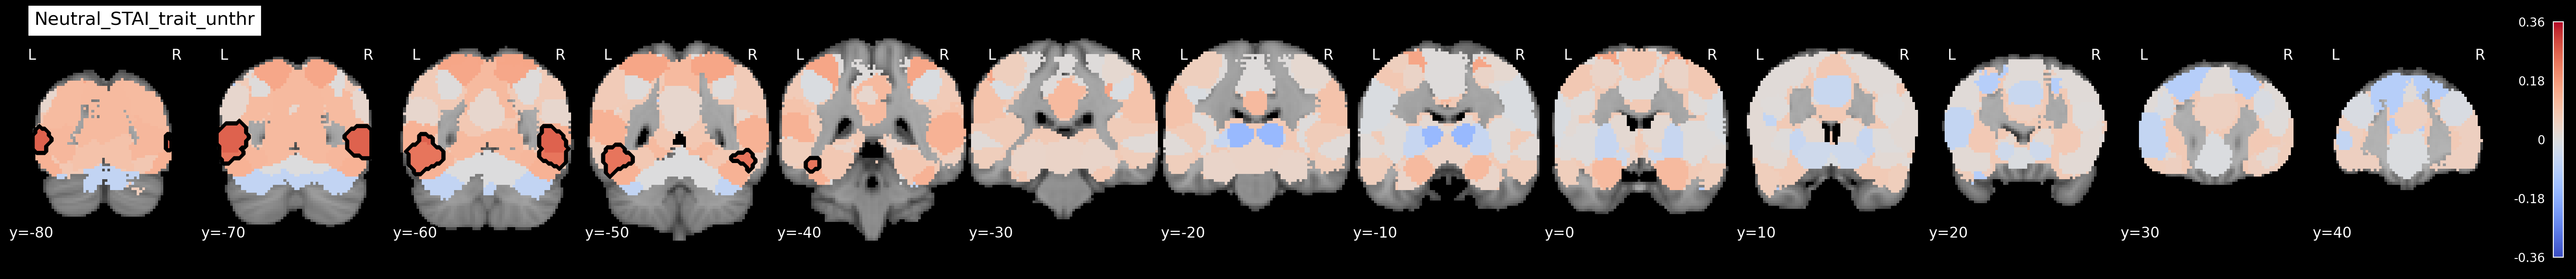

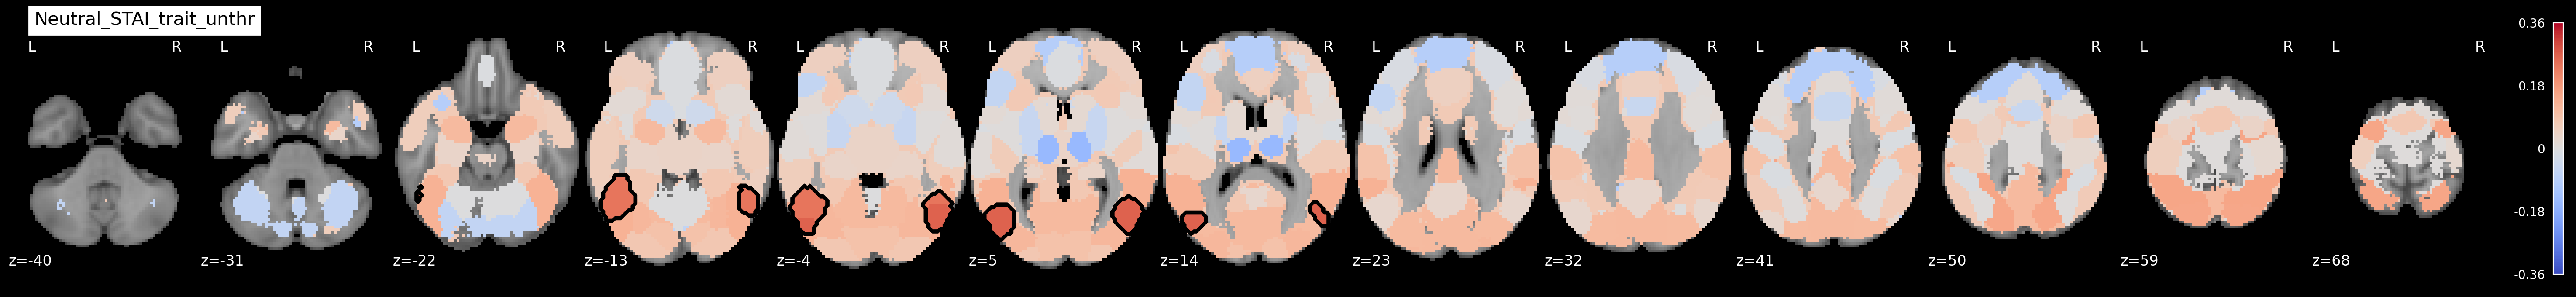

In [18]:
make_brainmap('Neutral_pre', 'STAI_trait', 50, 'eucosine', 'isrsa',vmax=0.36,method='FWE', draw_null=True)

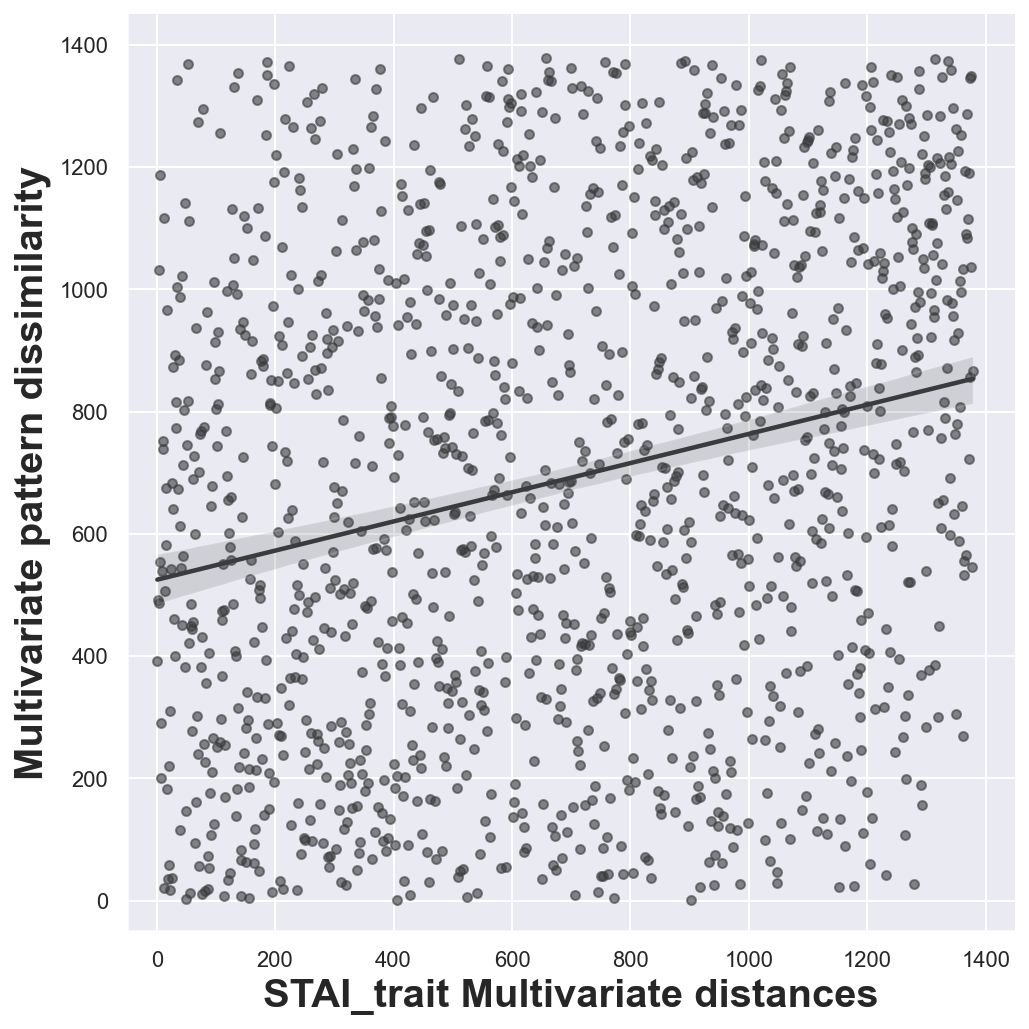

In [36]:
# fusiform gyrus
ISRSA_scatter_plots('Neutral_pre','STAI_trait',31,'eucosine',50, color='#3A3B3C')

## Figure S2

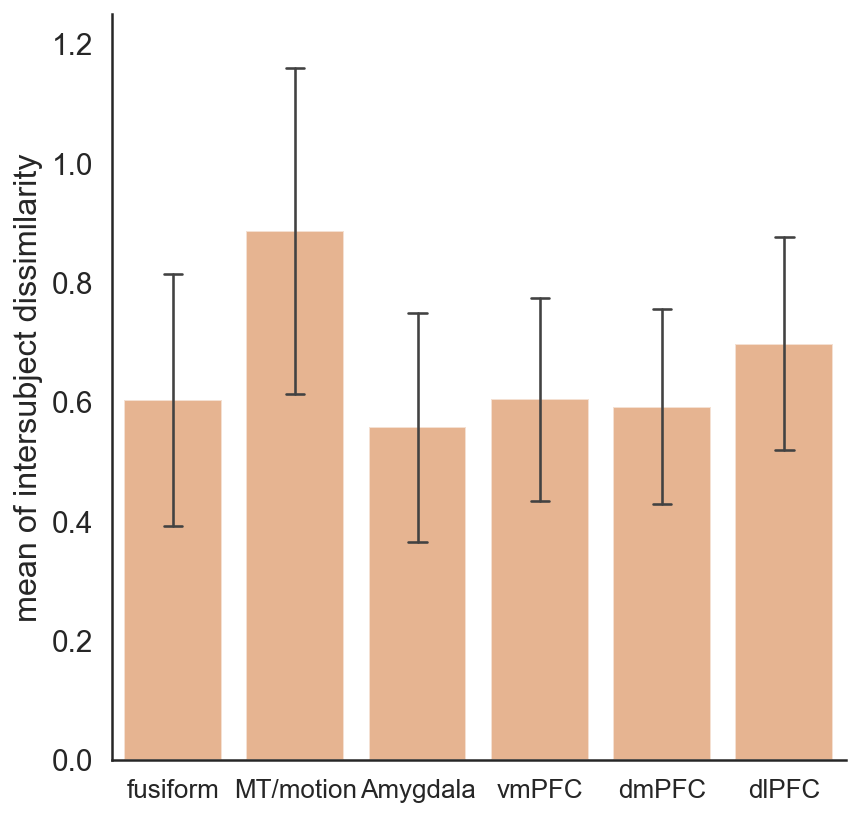

In [37]:
ISC_barplot('Positive_pre',[31,46,12,32,2,23],'mean','#ed7d31',50,'euclidean')

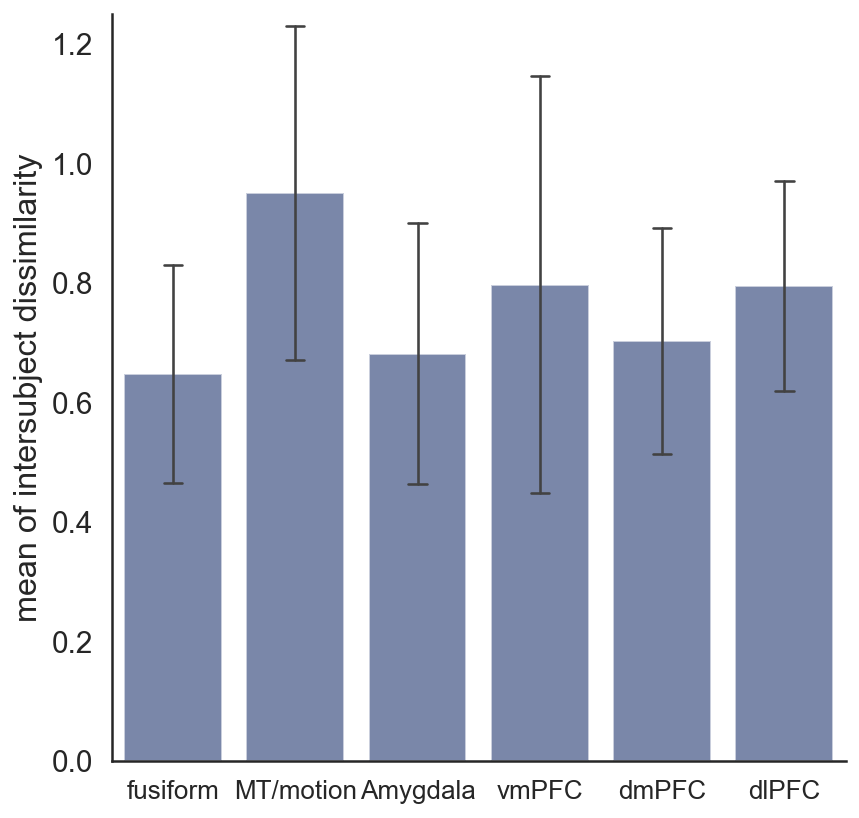

In [38]:
ISC_barplot('Negative_pre',[31,46,12,32,2,23],'mean','#15317E',50,'euclidean')

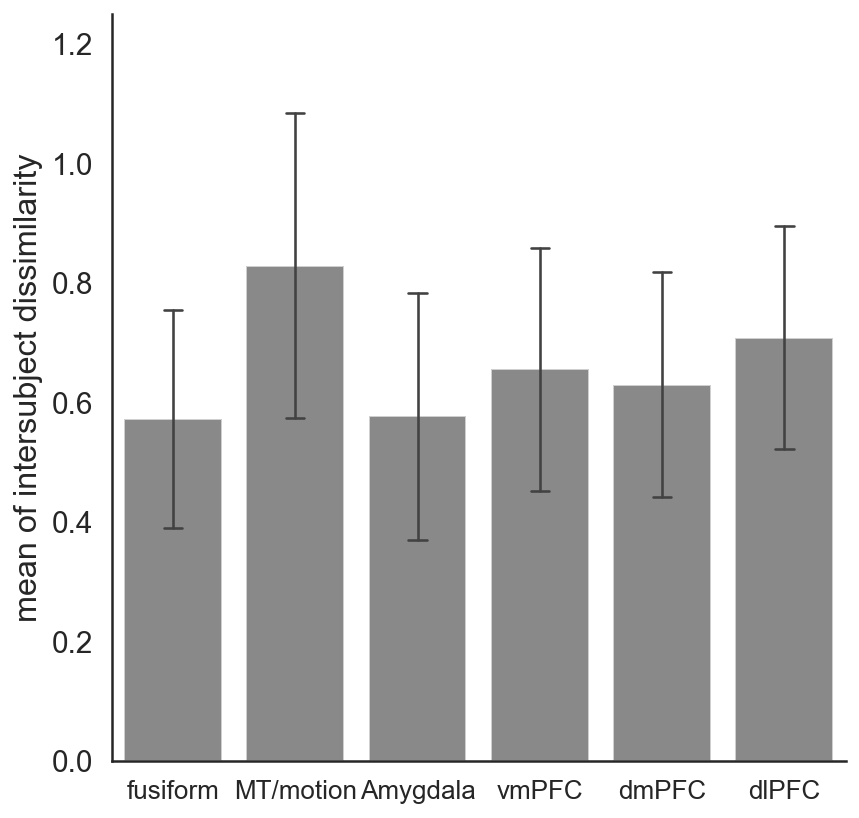

In [39]:
ISC_barplot('Neutral_pre',[31,46,12,32,2,23],'mean','#3A3B3C',50,'euclidean')

## Table S2

In [40]:
which_roi = [31,46,12,32,2,23]
condition = ['Negative vs. Positive','Negative vs. Neutral','Positive vs. Neutral']

roi = []
all_results = []
for i in tqdm(which_roi):
    
    results = []
    roi.append(name50[i])
    
    df = beta_df(i,'mean')
    for j in range(len(condition)):
        
        which_con = condition[j].split(' vs. ')
        rel = stats.ttest_rel(df[f'{which_con[0]}'], df[f'{which_con[1]}'])
        t = round(rel.statistic,2)
        if rel.pvalue < 0.001:
            r = '< 0.001'
        else:
            r = round(rel.pvalue,3)
            
        combine = f'{t} ({r})'
        results.append(combine)
    
    all_results.append(results)
    

df = pd.DataFrame(all_results, columns=condition, index=roi)
df

100%|██████████| 6/6 [00:20<00:00,  3.49s/it]


Negative vs. Positive Negative vs. Neutral Positive vs. Neutral
fusiform         5.61 (< 0.001)        9.1 (< 0.001)         2.55 (0.014)
MT/motion        5.25 (< 0.001)       7.68 (< 0.001)         3.13 (0.003)
Amygdala         5.58 (< 0.001)       7.53 (< 0.001)         1.26 (0.214)
vmPFC              0.12 (0.904)         1.25 (0.218)         1.54 (0.128)
dmPFC            3.64 (< 0.001)        6.5 (< 0.001)         3.39 (0.001)
dlPFC              1.44 (0.156)         2.92 (0.005)          1.92 (0.06)